In [11]:
import numpy as np
import pandas as pd
import scipy.optimize as scop
import matplotlib.pyplot as plt
import os
import ctypes
import sys
from sklearn.metrics import mean_squared_error as MSE
from scipy.interpolate import interp1d
import pygad
import pygmo as pg
from pygmo import *
import json

from cmaes import CMA
import optuna


In [12]:
plt.style.use('../styles/general.mplstyle')

In [13]:
sys.path.append("../src/python_scripts/")
from functions import scale, rescale, calculate_full_trace, OLD_calculate_full_trace, give_me_ina, OLD_give_me_ina,OLD_loss, loss,spec_log_scale,  despec_log_scale


In [14]:
filename_protocol = "../data/protocols/protocol_79.csv"
df_protocol = pd.read_csv(filename_protocol, index_col=0) 
df_protocol.t[0]

0.0

In [15]:
dirname = '../src/model_ctypes/ina/'

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')['value']

In [16]:
pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name').value.values

array([-80., -80., -80.,   0.,   1.,   1.,   0.])

In [17]:
S = legend_states.copy()
R = S.copy() * 0
C = legend_constants.copy()
A = legend_algebraic.copy()

output_len = len(df_protocol)

In [18]:
bounds = np.array((C.bound_1.values[:-2],C.bound_2.values[:-2]))
scale_bounds = np.array([[0.,1.] for k in range(len(bounds.T))])


In [19]:
a = np.concatenate((np.log(bounds[0][:-8]), bounds[0][-8:]))
a

array([-3.22361913e+01, -2.53284360e+01,  6.90775528e+00,  2.30258509e+00,
        2.30258509e+00,  0.00000000e+00, -2.30258509e+00,  4.60517019e+00,
        2.30258509e+00,  2.30258509e+00, -2.30258509e+00,  9.21034037e+00,
        0.00000000e+00,  4.60517019e+00, -9.21034037e+00,  1.61180957e+01,
        1.15129255e+01,  9.21034037e+00, -2.30258509e+00, -1.15129255e+01,
        1.00000000e+01,  5.00000000e+01,  1.00000000e+00,  1.00000000e+00,
        1.00000000e-02,  1.00000000e-02,  7.00000000e-01, -1.50000000e+01])

In [20]:
bounds=np.array([[-30.14184674, -26.14184674],
       [-25.71899811, -21.71899811],
       [ 9,  13],
       [  -1. ,   3. ],
       [ 0.,  4.],
       [  0.5 ,   4.5 ],
       [ -4.16282315,  -0.16282315],
       [  5.3588309 ,   9.3588309 ],
       [  1.17805383,   5.17805383],
       [  1.8286414 ,   5.8286414 ],
       [  4.04878828,  10.04878828],
       [-11.08812274,  -7.08812274],
       [  0.11384297,   4.11384297],
       [  1.64805746,   5.64805746],
       [ -5.91202301,  -1.91202301],
       [ 15.03438638,  19.03438638],
       [  9.15625052,  13.15625052],
       [  4.05678401,   9.05678401],
       [ -2.        ,   2.        ],
       [ -11.5129    ,   -7.41858    ],
       [  0.34180581,   50],
       [  20,   90],
       [  1e-3,   20],
       [ 1e-3,   20],
       [ 0.01,   1.77685645],
       [ 0.01,   2],
       [ 0.74    ,   0.76    ],
       [ -3.        ,   3.        ]])

In [21]:
diff = (df_protocol.v.shift() - df_protocol.v).fillna(0)
mask_capacity = diff.rolling(window=200).sum() !=0
indices_weight_c = mask_capacity.index.to_numpy()[mask_capacity] + 15

mask_INa = diff.rolling(window=600).sum()<-10
indices_weight_INa = mask_INa.index.to_numpy()[mask_INa] + 15

weight = np.zeros_like(df_protocol.v) + 5
weight[indices_weight_c] = 10
weight[indices_weight_INa] = 30

## LSODA

In [22]:
filename = 'ina.so'
filename_so = os.path.join(dirname, filename)
filename_abs = os.path.abspath(filename_so)
filename_abs

'/home/nik/Documents/comparison/INa_full_trace/src/model_ctypes/ina/ina.so'

In [23]:
p0  = C.value.values[:-2].copy()
p = spec_log_scale(p0)
p = np.concatenate((np.log(p0[:-8]), p0[-8:]))

In [24]:
##KWARGS WORKING
t0 = np.arange(0, 1, 5e-5)
v0 = np.full_like(t0, -80.0)
initial_state_len = len(t0)

t = df_protocol['t'].values
v = df_protocol['v'].values

output_len = len(t)
initial_state_S = pd.DataFrame(np.zeros((initial_state_len, len(S))), columns=legend_states.index)
initial_state_A = pd.DataFrame(np.zeros((initial_state_len, len(A))), columns=legend_algebraic.index)

output_S = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
output_A = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

ina = give_me_ina(filename_abs)
kwargs = dict(S = S,
              t0 = t0,
              v0 = v0,
              #initial_state_S = initial_state_S,
              #initial_state_A = initial_state_A,
              #initial_state_len = initial_state_len,
              #function = ina,
              #dt = 1e-8,
              filename_abs = filename_abs, 
              t = df_protocol['t'].values,
              v = df_protocol['v'].values,
              #output_S = output_S,
              #output_A = output_A,
              #bounds = bounds,
              #sample_weight = weight,
              #rescale = True,
              old_log = True
              #log = True,
             )


In [25]:
#res1 = pd.DataFrame(np.array((t0, v0)).T, columns=['t', 'v'])
#res1.to_csv('../data/protocols/protocol_initial_state.csv')

In [26]:
spec_log_bounds = np.array([spec_log_scale(bounds[0]),spec_log_scale(bounds[1])])
spec_log_bounds

../src/python_scripts/functions.py:270: RuntimeWarning: invalid value encountered in log
  y[:4] = np.log(y[:4])


IndexError: index 27 is out of bounds for axis 0 with size 2

In [27]:
p = np.array([-2.75666759e+01, -2.45169355e+01,  7.50956909e+00,  1.44161398e+00,
        1.79332247e+00,  3.93559661e+00, -2.09187346e+00,  5.89982192e+00,
        2.69935633e+00,  5.52496945e+00,  8.41710247e+00, -1.07446595e+01,
        3.68838534e-01,  1.59149800e-01, -7.33904986e+00,  1.94084108e+01,
        1.29060380e+01,  1.10000000e+01, -8.28336266e-01,  -9.21,
       2.42791000e+01,
        5.88927366e+01,  7.55695251e+00,  6.47187180e+00,  6.63918488e-03,
        4.02279734e-02,  7.50000000e-01, -1.00000000e+01])

In [28]:
%%time
res_ina = calculate_full_trace(p, kwargs)

CPU times: user 110 ms, sys: 4.13 ms, total: 114 ms
Wall time: 115 ms


In [29]:
for k in range(len(C)):
    print('"',C.T.columns[k],'" : {\n\t "bounds" : [', C.bound_1.values[k],',',C.bound_2.values[k],
          '],\n\t "gamma":', C.value.values[k],',\n\t"is_multiplier": false \n\t}')

" с_p " : {
	 "bounds" : [ 1e-14 , 5.0000000000000005e-12 ],
	 "gamma": 4.502962999999999e-12 ,
	"is_multiplier": false 
	}
" c_m " : {
	 "bounds" : [ 1.0000000000000001e-11 , 9.000000000000001e-11 ],
	 "gamma": 2.473016e-11 ,
	"is_multiplier": false 
	}
" a0_m " : {
	 "bounds" : [ 1000.0 , 10000.0 ],
	 "gamma": 2736.9559999999997 ,
	"is_multiplier": false 
	}
" b0_m " : {
	 "bounds" : [ 10.0 , 100.0 ],
	 "gamma": 71.35904000000001 ,
	"is_multiplier": false 
	}
" delta_m " : {
	 "bounds" : [ 10.0 , 100.0 ],
	 "gamma": 20.6157 ,
	"is_multiplier": false 
	}
" s_m " : {
	 "bounds" : [ 1.0 , 10.0 ],
	 "gamma": 9.306083000000001 ,
	"is_multiplier": false 
	}
" a0_h " : {
	 "bounds" : [ 0.1 , 1.0 ],
	 "gamma": 0.46040519999999996 ,
	"is_multiplier": false 
	}
" b0_h " : {
	 "bounds" : [ 100.0 , 1000.0 ],
	 "gamma": 503.8082 ,
	"is_multiplier": false 
	}
" delta_h " : {
	 "bounds" : [ 10.0 , 100.0 ],
	 "gamma": 15.2348 ,
	"is_multiplier": false 
	}
" s_h " : {
	 "bounds" : [ 10.0 , 100.0 ],
	

In [30]:
%matplotlib notebook

<IPython.core.display.Javascript object>


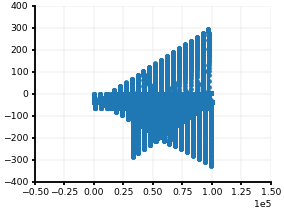

In [31]:
plt.figure()
plt.plot(res_ina, '.-')


In [37]:
A = pd.DataFrame(np.array([df_protocol.t,res_ina]).T, columns=["t", "V"])
A.to_csv('../data/training/artificial_data.csv')

In [32]:
df_protocol.t

0        0.00000
1        0.00005
2        0.00010
3        0.00015
4        0.00020
          ...   
99995    4.99975
99996    4.99980
99997    4.99985
99998    4.99990
99999    4.99995
Name: t, Length: 100000, dtype: float64

In [21]:
import pypoptim

ModuleNotFoundError: No module named 'pypoptim'

## OLD

In [31]:
OLD_dirname = '../src/model_ctypes/ina_old/'

In [32]:
OLD_filename = 'ina_old.so'
OLD_filename_so = os.path.join(OLD_dirname, OLD_filename)
OLD_filename_abs = os.path.abspath(OLD_filename_so)
OLD_filename_abs

'/home/nik/Documents/comparison/INa_full_trace/src/model_ctypes/ina_old/ina_old.so'

In [61]:
##KWARGS WORKING OLD
OLD_t0 = np.arange(0, 0.5, 5e-5)
OLD_v0 = np.full_like(OLD_t0, -80.0)
OLD_initial_state_len = len(OLD_t0)

output_len = len(df_protocol.t)
p0  = C.value.values[:-2]
OLD_initial_state_S = pd.DataFrame(np.zeros((OLD_initial_state_len, len(S))), columns=legend_states.index)
OLD_initial_state_A = pd.DataFrame(np.zeros((OLD_initial_state_len, len(A))), columns=legend_algebraic.index)

OLD_output_S = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
OLD_output_A = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

OLD_ina = OLD_give_me_ina(OLD_filename_abs)
OLD_kwargs = dict(S = S,
              t0 = OLD_t0,
              v0 = OLD_v0,
              initial_state_S = OLD_initial_state_S,
              initial_state_A = OLD_initial_state_A,
              initial_state_len = OLD_initial_state_len,
              #function = ina,
              dt = 1e-7,
              filename_abs = OLD_filename_abs, 
              t = df_protocol['t'].values,
              v = df_protocol['v'].values,
              output_S = OLD_output_S,
              output_A = OLD_output_A,
              bounds = bounds,
              sample_weight = weight,
              rescale= True
             )


NameError: name 'OLD_filename_abs' is not defined

In [34]:
%%time
OLD_res = OLD_calculate_full_trace(scale(p0,*bounds), OLD_kwargs)

CPU times: user 11 s, sys: 0 ns, total: 11 s
Wall time: 11 s


In [35]:
%%time
OLD_loss(scale(p0,*bounds), OLD_res, OLD_kwargs)

CPU times: user 10.7 s, sys: 0 ns, total: 10.7 s
Wall time: 10.7 s


0.0

<IPython.core.display.Javascript object>


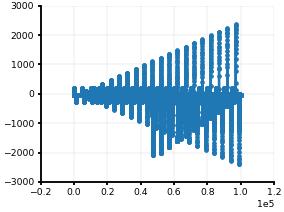

In [36]:
plt.figure()
plt.plot(OLD_res, '.-')

<IPython.core.display.Javascript object>


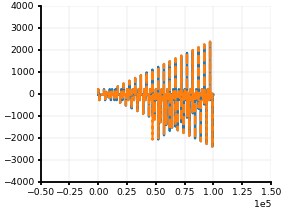

In [37]:
plt.figure()
plt.plot(res_ina)
plt.plot(OLD_res, '--')

## MINIMIZATION

### differential evolution

In [20]:
x = p + 0.1
loss(x, res_ina,kwargs)

668.000367347998

<IPython.core.display.Javascript object>


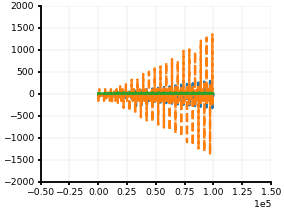

In [22]:
plt.figure()
plt.plot(res_ina)
plt.plot(calculate_full_trace(x, kwargs),'--')
plt.plot(weight)

In [23]:
%%time
res = scop.differential_evolution(loss,
                                  #bounds=scale_bounds,
                                  bounds=bounds,
                                  args=(res_ina, kwargs),
                                  maxiter=10, 
                                  popsize = 10,
                                  #workers = 1,
                                  disp = True,
                                  #atol = 10000,
                                  seed=42,
                                  polish=False
                                 )

differential_evolution step 1: f(x)= 1156.22
differential_evolution step 2: f(x)= 1121.79
differential_evolution step 3: f(x)= 1088.35
differential_evolution step 4: f(x)= 1088.35
differential_evolution step 5: f(x)= 1081.43
differential_evolution step 6: f(x)= 1081.43
differential_evolution step 7: f(x)= 1081.43
differential_evolution step 8: f(x)= 1081.43
differential_evolution step 9: f(x)= 1081.43
differential_evolution step 10: f(x)= 1073.81
CPU times: user 4min 47s, sys: 235 ms, total: 4min 47s
Wall time: 4min 48s


In [67]:
p  = np.array([-2.89522371e+01, -2.40980733e+01,
               8.900000000e+00,  1.30084225e-01,
               2.92854540e-01,  4.03635899e+00,
               -4.02622280e+00,  7.34940407e+00,
               1.22898378e+00,  2.41761933e+00,
               4.65790715e+00, -1.07403698e+01,
               5.08000035e-01,  2.45752646e+00,
               -5.91202301e+00,  1.90343864e+01,
               1.20688569e+01,  6.63657592e+00,
               -6.91753629e-01,  -9.210340371976182,
               2.39220213e+01,  3.81207253e+01,
               7.55601327e+00,  1.00000000e-03,
               3.81455356e-01,  1.74305597e+00, 
               1.00000000e-05, -2.89128574e-01])

In [177]:
#DON'T DELETE THIS CELL
#5.6 s - 1 organism
5.6*50/60

4.666666666666667

In [178]:
x_dif_eval = np.array([0.80316885, 0.1206271 , 0.79508232, 0.03118913, 0.57236395,
       0.61833792, 0.83374858, 0.02567316, 0.25540739, 0.49903152,
       0.57422094, 0.99544661, 0.66033478, 0.07506811, 0.3581428 ,
       0.99794034, 0.0857484 , 0.28062788, 0.2108846 , 0.99780891,
       0.2482435 , 0.48800992, 0.2019317 , 0.67098083, 0.35207935,
       0.36821815, 0.83867293, 0.4212081 ])

In [179]:
x_cma = np.array([0.3737163054872696,0.31346190464033596,0.6396596667296667,0.8071168647286047,0.03316198803009691,0.012802645678700977,0.37314314173988333,0.5799357528019566,0.2675351776357948,0.646702021207199,0.5890960448530488,0.444875641480323,0.2747447769492345,0.6072180280072074,0.3028826933570755,0.9914615501734555,0.11716257699834351,0.6112661865878747,0.0006863249701580082,0.9991332792537969,0.4687480152243966,0.2325632558087526,0.001261406907863551,0.1931942628066086,0.482212230264882,0.38742915622772267,0.9136597295444432,0.2182623134154159])

In [180]:
res_dif_eval = calculate_full_trace(x_dif_eval,kwargs)
res_cma = calculate_full_trace(x_cma,kwargs)


In [71]:
%matplotlib notebook

<IPython.core.display.Javascript object>


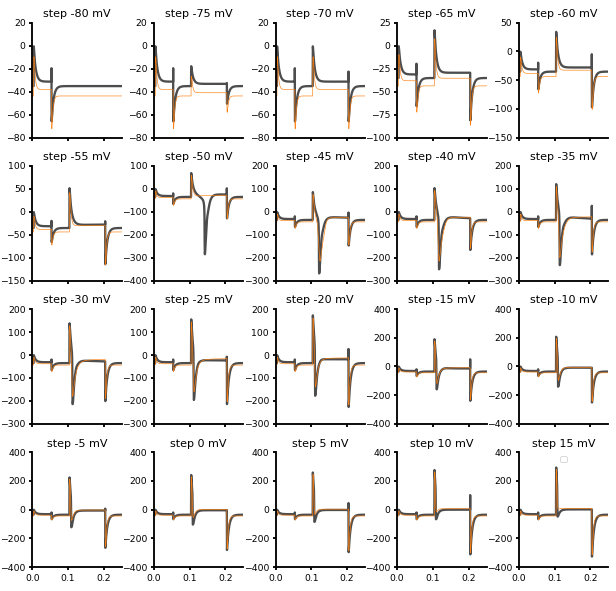

No handles with labels found to put in legend.
<ipython-input-72-103a8136d3fd>:44: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


In [72]:
n_sections = 20
split_indices = np.linspace(0, len(df_protocol.v), n_sections + 1).astype(int)
nrows, ncols = 4, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=plt.figaspect(nrows / ncols) * 2,
                             sharex=True)

I_out =calculate_full_trace(res_dual_annealing_2.x, kwargs)
real_data_all = res_ina
dt = 5e-5

colors = ['0.3', 'C1']

i_global = 0

for i_row in range(nrows):
    for i_col in range(ncols):
        ax = axes[i_row, i_col]
        plt.sca(ax)

        i_start, i_end = split_indices[i_global], split_indices[i_global + 1]
        slice_current = slice(i_start, i_end)

        I_out_current = I_out[slice_current]
        data_current  = real_data_all[slice_current]
        t = np.arange(len(data_current)) * dt
            
            #for k in output_A.columns[6:9]:
            #    plt.plot(t,output_A[k][slice_current], '.-', label = k)
           # for k in output_A.columns[10:10]:
            #    plt.plot(t,output_A[k][slice_current], '.-', label = k)    

        plt.plot(t, data_current, color=colors[0])
        plt.plot(t, I_out_current, lw=0.68, color=colors[1])
        plt.xlim(0,0.25)
        plt.grid()

        step_value = -80 + 5 * i_global
        title = f'step {step_value} mV'
        plt.title(title)
    
        i_global += 1
plt.legend()
plt.tight_layout()
folder_save = "../data/pictures/results"
filename_prefix = 'ga'
#plt.title(filename_prefix)
#plt.show()
    
filename_save = os.path.join(folder_save, f'{filename_prefix}_grid.png')

#plt.savefig(filename_save, dpi=300)

In [44]:
V=np.arange(-100,30)

In [48]:
#const_20, const_22
def m_inf(v_m, x):
    v_half = x[20]
    k_m = x[22]
    m = 1 / (1 + np.exp((- v_half - v_m) / k_m))
    return m
#const_21, const_23
def h_inf(v_m, x):
    v_half = x[21]
    k_h = x[23] 
    h = 1 / (1 + np.exp((v_half + v_m) / k_h))
    return h

def tau_m(v_m, x):
    a0_m = x[2]
    s_m = x[5]
    b0_m = x[3]
    delta_m = x[4]
    t_m = 1 / (a0_m * np.exp(v_m / (s_m)) + b0_m * np.exp(v_m / (-delta_m)))
    return t_m
def tau_h(v_m, x):
    a0_h = x[6]
    s_h = x[9]
    b0_h = x[7]
    delta_h = x[8]
    t_h = 1 / (a0_h * np.exp(v_m / (-s_h)) + b0_h * np.exp(v_m / (delta_h)))
    return t_h
def tau_j(v_m, x):
    tau_j_const = x[14]
    a0_j = x[10]
    s_j = x[13]
    b0_j = x[11]
    delta_j = x[12]
    t_j = tau_j_const + 1 / (a0_j * np.exp(v_m / (s_j)) + b0_j * np.exp(v_m/ (-delta_j)))
    return t_j


### dual_annealing

In [29]:
x0 = p + 0.1
x0

array([-27.4666759 , -24.4169355 ,   7.60956909,   1.54161398,
         1.89332247,   4.03559661,  -1.99187346,   5.99982192,
         2.79935633,   5.62496945,   8.51710247, -10.6446595 ,
         0.46883853,   0.2591498 ,  -7.23904986,  19.5084108 ,
        13.006038  ,  11.1       ,  -0.72833627,  -9.11      ,
        24.3791    ,  58.9927366 ,   7.65695251,   6.5718718 ,
         0.10663918,   0.14022797,   0.85      ,  -9.9       ])

In [47]:
p0 = np.concatenate((np.exp(p[:-8]), p[-8:]))

In [43]:
res_d_a_0 = np.concatenate((np.exp(res_dual_annealing.x[:-8]),res_dual_annealing.x[-8:])) 

In [63]:
res_d_a_0 = np.concatenate((np.exp(res_dual_annealing_2.x[:-8]),res_dual_annealing_2.x[-8:]))

In [56]:
V = np.arange(-80, 30)

In [57]:
res_d_a_0

array([2.77171674e-12, 1.91962915e-11, 2.57921375e+04, 2.26802841e+00,
       4.68646709e+00, 3.90584458e+00, 8.23655377e-02, 2.91339744e+02,
       1.64119389e+01, 2.10307417e+01, 3.60219935e+02, 2.03799939e-04,
       6.23934878e+00, 2.23775511e+01, 8.43134194e-02, 1.74307353e+08,
       8.70147157e+04, 1.12734296e+03, 6.17030799e-01, 1.36884153e-04,
       3.23087220e+01, 8.63330852e+01, 6.37633114e+00, 1.04844331e+01,
       1.27437657e-01, 1.93190515e+00, 1.63576114e-02, 1.45283418e+00])

In [73]:
p0

array([ 1.06646049e-12,  2.25128356e-11,  1.82542678e+03,  4.22751344e+00,
        6.00938534e+00,  5.11926829e+01,  1.23455630e-01,  3.64972468e+02,
        1.48701572e+01,  2.50878674e+02,  4.52377667e+03,  2.15602439e-05,
        1.44605410e+00,  1.17251358e+00,  6.49667503e-04,  2.68513245e+08,
        4.02736588e+05,  5.98741417e+04,  4.36775360e-01,  1.00034043e-04,
        2.42791000e+01,  5.88927366e+01,  7.55695251e+00,  6.47187180e+00,
        6.63918488e-03,  4.02279734e-02,  7.50000000e-01, -1.00000000e+01])

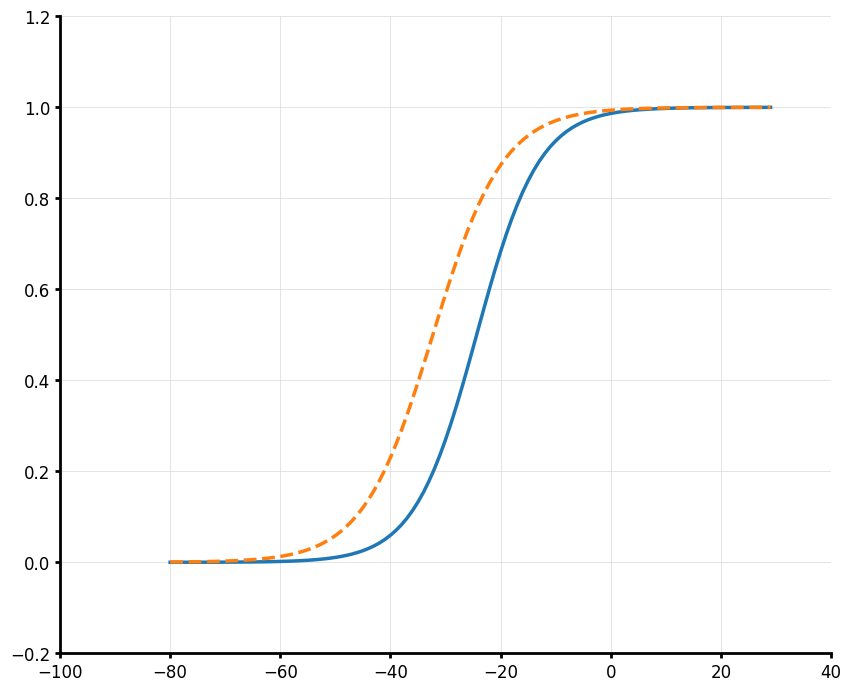

In [64]:
plt.figure()
plt.plot(V,m_inf(V, p0))
plt.plot(V,m_inf(V,res_d_a_0),'--')

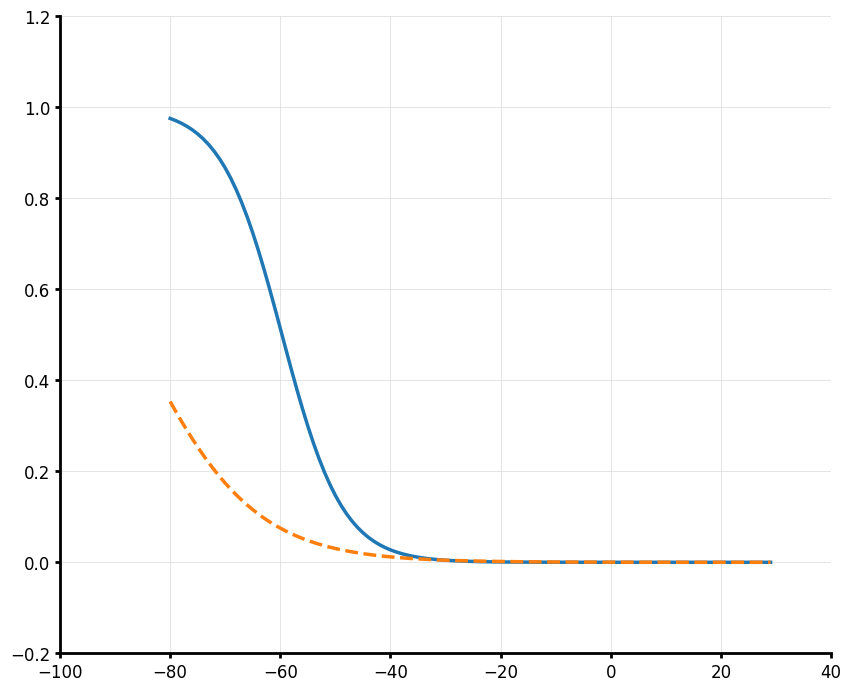

In [65]:
plt.figure()
plt.plot(V,h_inf(V, p0))
plt.plot(V,h_inf(V,res_d_a_0), '--')

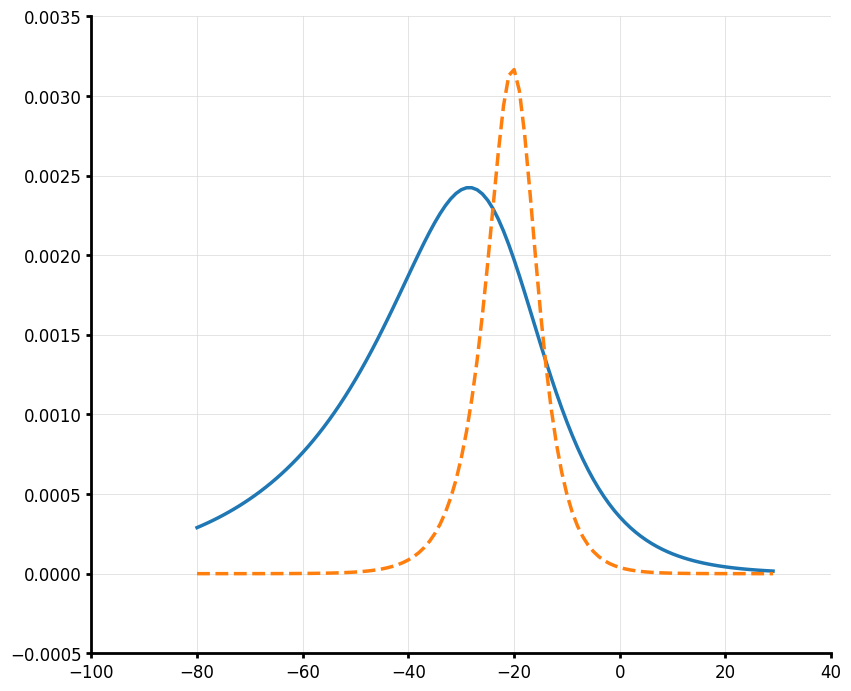

In [66]:
plt.figure()
plt.plot(V,tau_m(V, p0))
plt.plot(V,tau_m(V,res_d_a_0),'--')

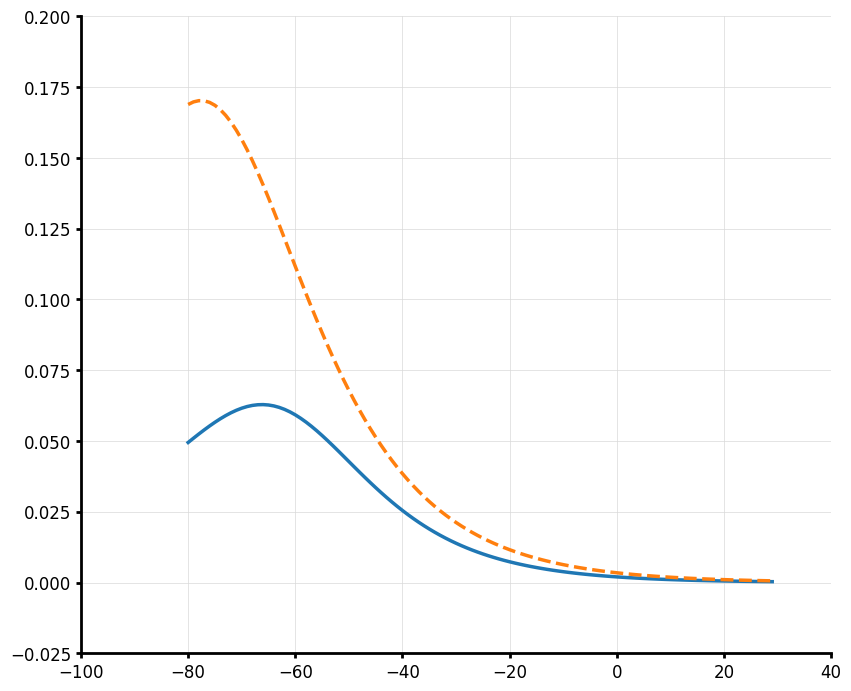

In [67]:
plt.figure()
plt.plot(V,tau_h(V, p0))
plt.plot(V,tau_h(V,res_d_a_0),'--')

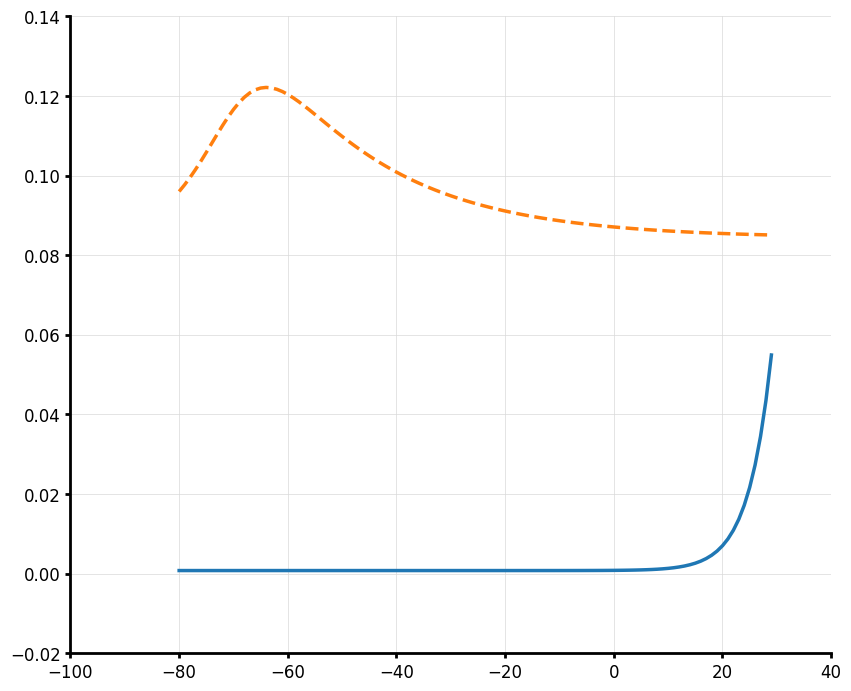

In [68]:
plt.figure()
plt.plot(V,tau_j(V, p0))
plt.plot(V,tau_j(V,res_d_a_0),'--')

In [26]:
np.save('res_ina',res_ina)


In [21]:
x0 = np.array([-27.4666759 , -24.4169355 ,   7.60956909,   1.54161398,
         1.89332247,   4.03559661,  -1.99187346,   5.99982192,
         2.79935633,   5.62496945,   8.51710247, -10.6446595 ,
         0.46883853,   0.2591498 ,  -7.23904986,  19.5084108 ,
        13.006038  ,  11.1       ,  -0.72833627,  -9.11      ,
        20.3791    ,  38.9927366 ,   3.65695251,   7.5718718 ,
         0.10663918,   0.14022797,   0.85      ,  -9.9       ])

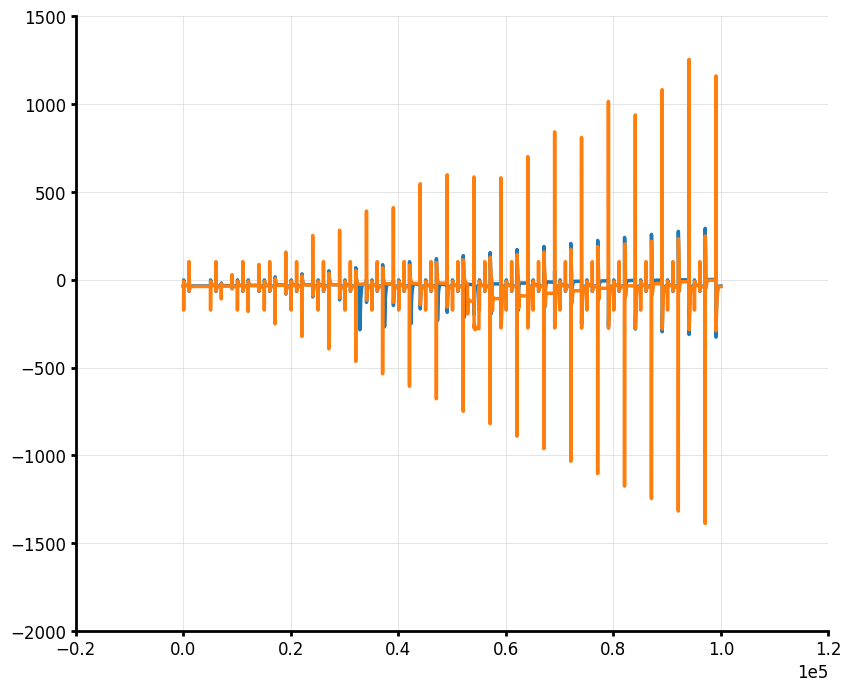

In [29]:
plt.plot(res_ina)
plt.plot(calculate_full_trace(x0, kwargs))

In [30]:
%%time
res_dual_annealing = scop.dual_annealing(loss, bounds= bounds, x0 = x0, args=(res_ina, kwargs), seed=38, maxiter=10)


CPU times: user 21min 59s, sys: 1.63 s, total: 22min
Wall time: 22min 14s


In [31]:
%%time
res_dual_annealing_2 = scop.dual_annealing(loss, bounds= bounds, x0 = res_dual_annealing.x, args=(res_ina, kwargs), seed=38, maxiter=10)


CPU times: user 11min 52s, sys: 1.4 s, total: 11min 53s
Wall time: 12min 4s


In [41]:
loss(res_dual_annealing.x, res_ina, kwargs)

234.04959023948126

In [40]:
sum((calculate_full_trace(res_dual_annealing.x, kwargs) - res_ina)**2)


23404959.02394791

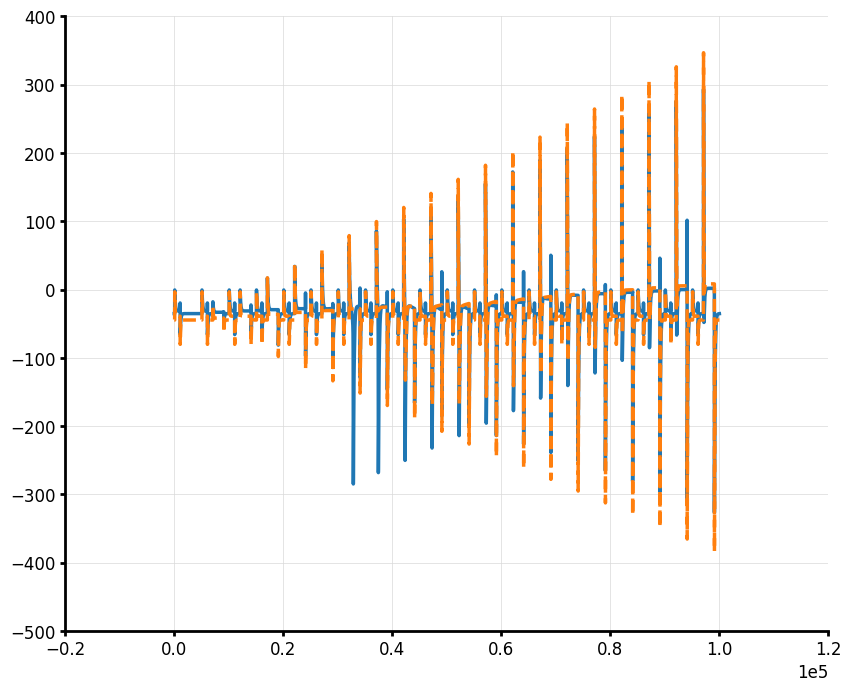

In [42]:
plt.figure()
plt.plot(res_ina)
plt.plot(calculate_full_trace(res_dual_annealing.x, kwargs),'--')
#plt.plot(calculate_full_trace(x0, kwargs))
#plt.plot(weight)

In [90]:
loss(res_dual_annealing_real_2.x, res_ina, kwargs)

187.2069979491856

In [41]:
res_dual_annealing.x

array([-28.23054815, -24.51897471,   7.60956909,  -0.79628998,
         1.89332247,   4.03559661,  -2.92596478,   7.03006932,
         2.79935633,   5.0802962 ,   5.53663479, -10.63403115,
         0.67283664,   4.19547101,  -7.23904986,  19.5084108 ,
        10.068224  ,  11.1       ,  -0.72833627,  -7.82494901,
        24.3791    ,  58.9927366 ,   7.65695251,   6.5718718 ,
         0.10663918,   1.87982421,   0.85      ,  -9.9       ])

In [ ]:
plt.plot()

In [42]:
p

array([-2.75666759e+01, -2.45169355e+01,  7.50956909e+00,  1.44161398e+00,
        1.79332247e+00,  3.93559661e+00, -2.09187346e+00,  5.89982192e+00,
        2.69935633e+00,  5.52496945e+00,  8.41710247e+00, -1.07446595e+01,
        3.68838534e-01,  1.59149800e-01, -7.33904986e+00,  1.94084108e+01,
        1.29060380e+01,  1.10000000e+01, -8.28336266e-01, -9.21000000e+00,
        2.42791000e+01,  5.88927366e+01,  7.55695251e+00,  6.47187180e+00,
        6.63918488e-03,  4.02279734e-02,  7.50000000e-01, -1.00000000e+01])

## MCMC

In [182]:
from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
import pymcmcstat

In [183]:
res_start = calculate_full_trace(x, kwargs)

In [184]:
x_list = np.arange(0, 0.25*20, 5e-5)


In [185]:
def func(xdata,theta):
    I = calculate_full_trace(theta, kwargs)
    return I

In [186]:
def loss_mcmc(x, data):
    y = np.concatenate((x.copy(), p[1:]))
    #return 42
    #args = kwargs
    #sample_weight = kwargs.get('sample_weight', None)
    n = len(data.xdata)
    
    I_out = func(data.xdata, y)
    dat = (I_out - np.array(data.ydata[0].T[0]))**2
    return sum(dat)

In [208]:
# initialize MCMC object
mcstat = MCMC()
# initialize data structure 
mcstat.data.add_data_set(x = x_list,
                         y = res_ina_noise)#,
                         #user_defined_object= kwargs)
# initialize parameter array
#theta = [0.5, 0.03, 0.1, 10, 0.02, 1.14, 0.77, 1.3, 10]
# add model parameters

mcstat.parameters.add_model_parameter(name=' с_p ', theta0= -26.126285491387264 , minimum= -32.23619130191664 , maximum= -26.021583203494448 )
#mcstat.parameters.add_model_parameter(name=' c_m ', theta0= -24.422997564541507 , minimum= -25.328436022934504 , maximum= -23.131211445598282 )
#mcstat.parameters.add_model_parameter(name=' a0_m ', theta0= 7.9146016329158435 , minimum= 6.907755278982137 , maximum= 9.210340371976184 )
#mcstat.parameters.add_model_parameter(name=' b0_m ', theta0= 4.267724035266465 , minimum= 2.302585092994046 , maximum= 4.605170185988092 )
#mcstat.parameters.add_model_parameter(name=' delta_m ', theta0= 20.6157 , minimum= 10.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' s_m ', theta0= 9.306083000000001 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' a0_h ', theta0= -0.7756483076716936 , minimum= -2.3025850929940455 , maximum= 0.0 )
#mcstat.parameters.add_model_parameter(name=' b0_h ', theta0= 6.222195640086172 , minimum= 4.605170185988092 , maximum= 6.907755278982137 )
#mcstat.parameters.add_model_parameter(name=' delta_h ', theta0= 15.2348 , minimum= 10.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' s_h ', theta0= 21.96405 , minimum= 10.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' a0_j ', theta0= -0.8039757298133126 , minimum= -2.3025850929940455 , maximum= 0.0 )
#mcstat.parameters.add_model_parameter(name=' b0_j ', theta0= 9.933693232885549 , minimum= 9.210340371976184 , maximum= 11.512925464970229 )
#mcstat.parameters.add_model_parameter(name=' delta_j ', theta0= 4.115303 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' s_j ', theta0= 167.3159 , minimum= 100.0 , maximum= 1000.0 )
#mcstat.parameters.add_model_parameter(name=' tau_j_const ', theta0= -7.156946006769279 , minimum= -9.210340371976182 , maximum= -6.907755278982137 )
#mcstat.parameters.add_model_parameter(name=' R ', theta0= 17.032254912863436 , minimum= 16.11809565095832 , maximum= 18.420680743952367 )
#mcstat.parameters.add_model_parameter(name=' R_f ', theta0= 12.695944463648372 , minimum= 11.512925464970229 , maximum= 13.815510557964274 )
#mcstat.parameters.add_model_parameter(name=' g_max ', theta0= 12.992756616186211 , minimum= 9.210340371976184 , maximum= 13.815510557964274 )
#mcstat.parameters.add_model_parameter(name=' g_leak ', theta0= -0.7313802376061298 , minimum= -2.3025850929940455 , maximum= 2.302585092994046 )
#mcstat.parameters.add_model_parameter(name=' tau_z ', theta0= -9.210000429763085 , minimum= -11.512925464970229 , maximum= -6.907755278982137 )
#mcstat.parameters.add_model_parameter(name=' v_half_m ', theta0= 24.35802 , minimum= 10.0 , maximum= 60.0 )
#mcstat.parameters.add_model_parameter(name=' v_half_h ', theta0= 59.69116999999999 , minimum= 50.0 , maximum= 100.0 )
#mcstat.parameters.add_model_parameter(name=' k_m ', theta0= 5.66677 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' k_h ', theta0= 5.507771 , minimum= 1.0 , maximum= 10.0 )
#mcstat.parameters.add_model_parameter(name=' x_c_comp ', theta0= -2.309616455184387 , minimum= -4.605170185988091 , maximum= 0.09531017980432493 )
#mcstat.parameters.add_model_parameter(name=' x_r_comp ', theta0= 0.01980262729617973 , minimum= -4.605170185988091 , maximum= 0.09531017980432493 )
#mcstat.parameters.add_model_parameter(name=' alpha ', theta0= -0.2876820724517809 , minimum= -0.35667494393873245 , maximum= -0.2231435513142097 )
#mcstat.parameters.add_model_parameter(name=' v_off ', theta0= 1.55814461804655 , minimum= 0.0 , maximum= 2.302585092994046 )


# Generate options
mcstat.simulation_options.define_simulation_options(nsimu=1.0e3, updatesigma=True)
# Define model object:
mcstat.model_settings.define_model_settings(sos_function=loss_mcmc, S20=np.array([1]),N0=np.array([4]))

In [209]:
s1 = loss_mcmc(p[:1], mcstat.data)
print('s1 = {}'.format(s1))

s1 = 2502940.848891833


In [210]:
# Run simulation

mcstat.run_simulation()



Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
      с_p :    -26.13 [   -32.24,    -26.02] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 1000 of 1000 complete in 352.6 sec

In [198]:
%matplotlib notebook


In [206]:
res_ina_noise = res_ina + np.random.normal(0,5,100000)

In [190]:
%matplotlib inline



------------------------------
      name:      mean       std    MC_err       tau    geweke
      с_p :    -26.13  3.55e-15  0.00e+00     -0.43      1.00
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 1.00%
Stage 2: 0.00%
Net    : 1.00% -> 1/100
---------------
Chain provided:
Net    : 2.00% -> 1/50
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


<IPython.core.display.Javascript object>


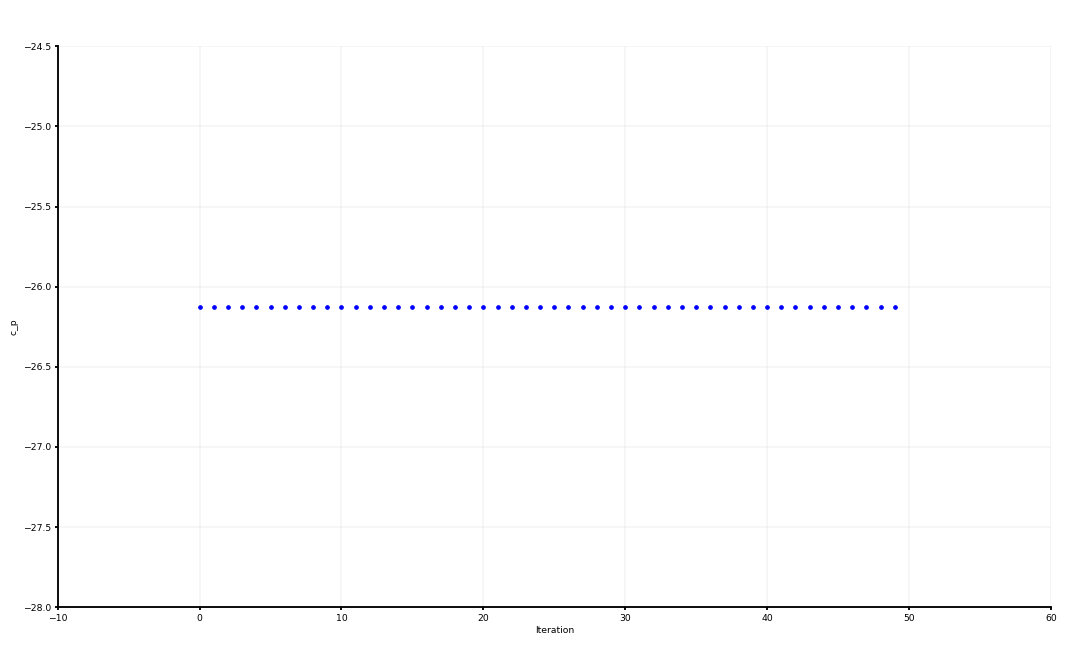

/home/nik/.local/lib/python3.8/site-packages/mcmcplot/mcmatplot.py:220: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=1.0)  # adjust spacing


<IPython.core.display.Javascript object>


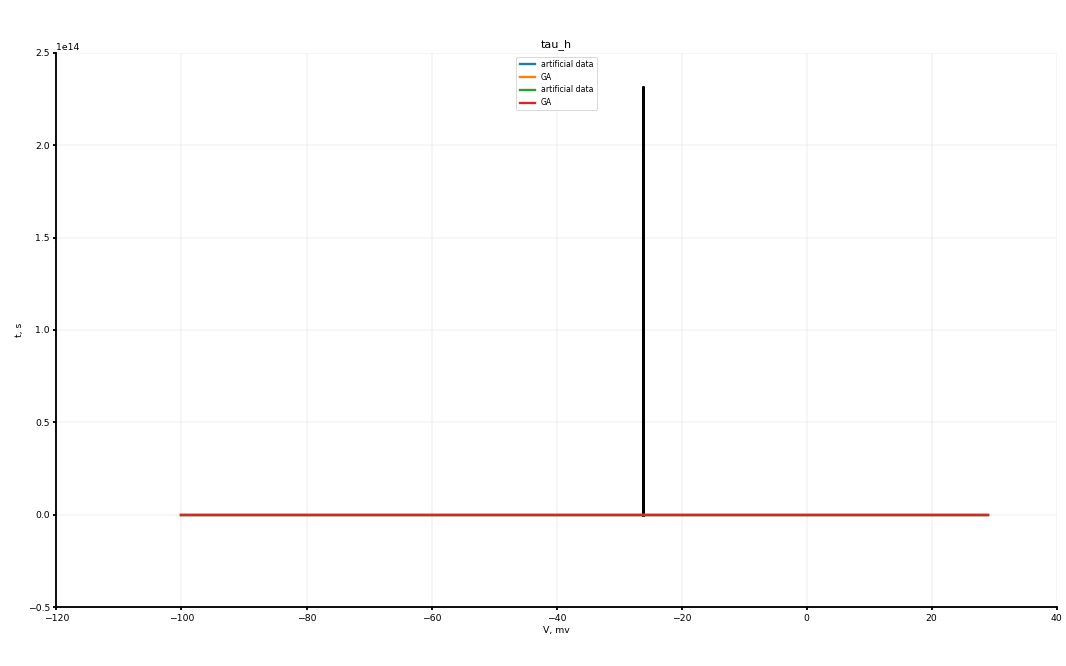

/home/nik/.local/lib/python3.8/site-packages/mcmcplot/mcmatplot.py:94: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=1.0)  # adjust spacing


<IPython.core.display.Javascript object>


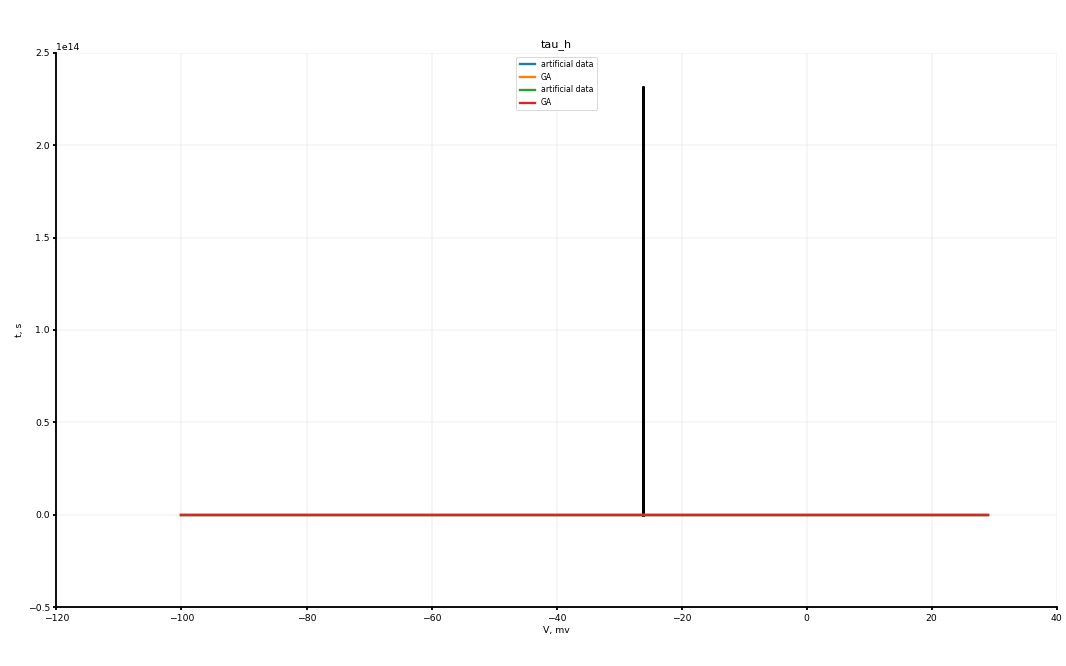

In [207]:
# extract info from results
results = mcstat.simulation_results.results
burnin = int(results['nsimu']/2)
chain = results['chain'][burnin:, :]
s2chain = results['s2chain'][burnin:, :]
names = results['names'] # parameter names

# display chain stats
mcstat.chainstats(chain, results)

from pymcmcstat import mcmcplot as mcp
settings = dict(
    fig=dict(figsize=(16, 10))
)
# plot chain panel
mcp.plot_chain_panel(chain, names, settings)
# plot density panel
mcp.plot_density_panel(chain, names, settings)
# pairwise correlation
#f = mcp.plot_pairwise_correlation_panel(chain, names, settings)

In [78]:
names

[' с_p ',
 ' c_m ',
 ' a0_m ',
 ' b0_m ',
 ' delta_m ',
 ' s_m ',
 ' a0_h ',
 ' b0_h ',
 ' delta_h ',
 ' s_h ',
 ' a0_j ',
 ' b0_j ',
 ' delta_j ',
 ' s_j ',
 ' tau_j_const ',
 ' R ',
 ' R_f ',
 ' g_max ',
 ' g_leak ',
 ' tau_z ',
 ' v_half_m ',
 ' v_half_h ',
 ' k_m ',
 ' k_h ',
 ' x_c_comp ',
 ' x_r_comp ',
 ' alpha ',
 ' v_off ']

In [84]:
len(chain.T)

28

<ipython-input-86-7ee6fb1f2af4>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


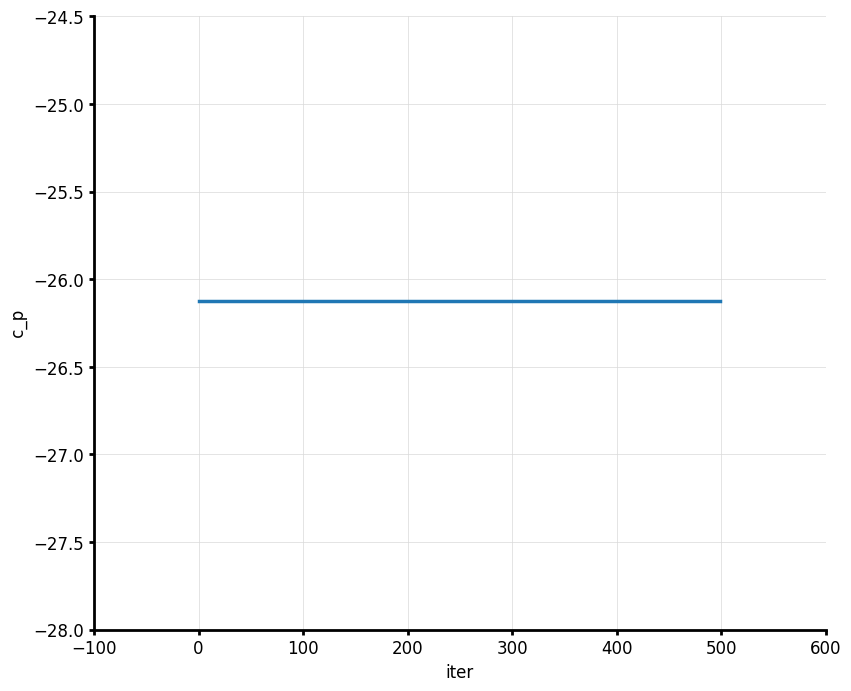

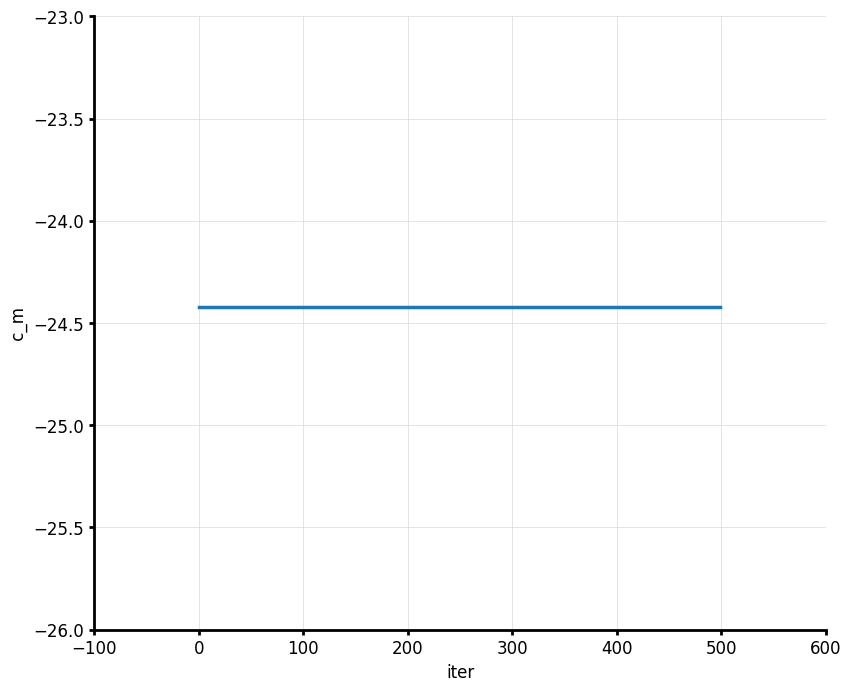

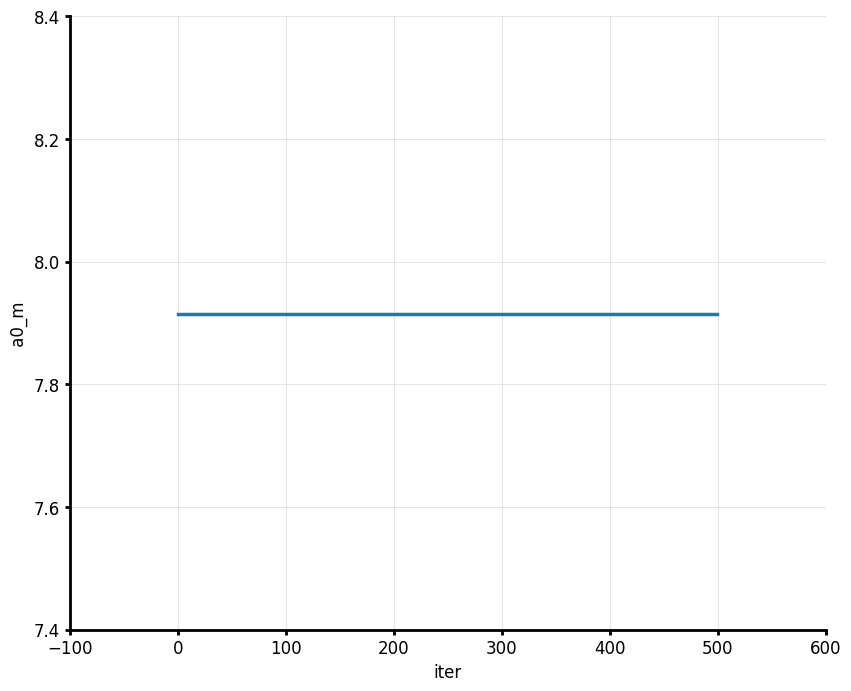

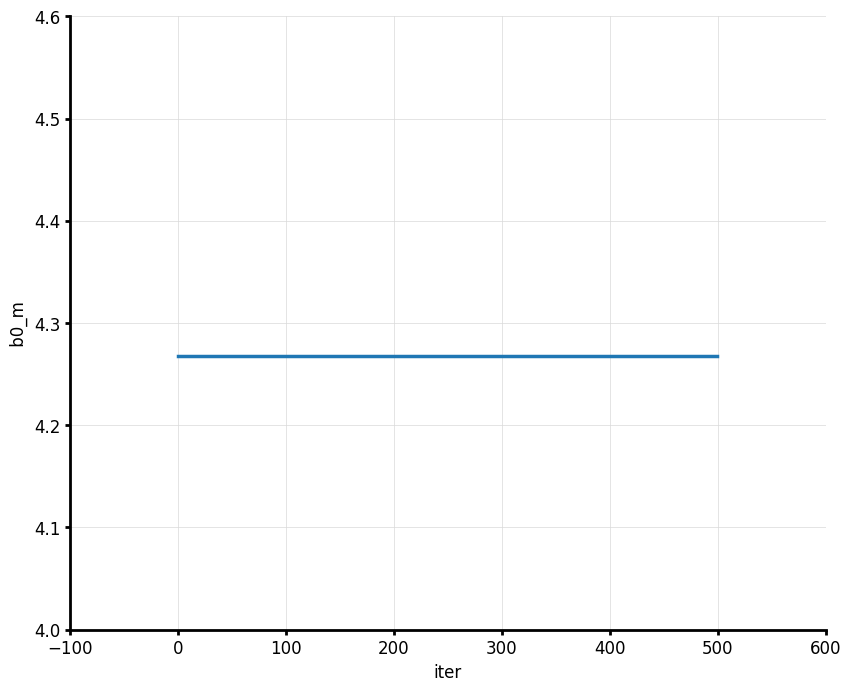

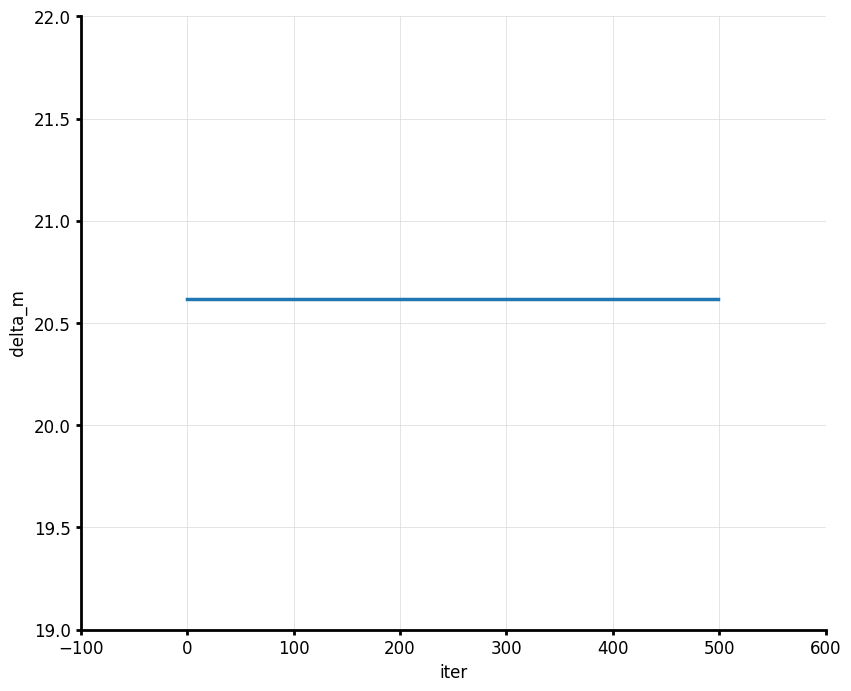

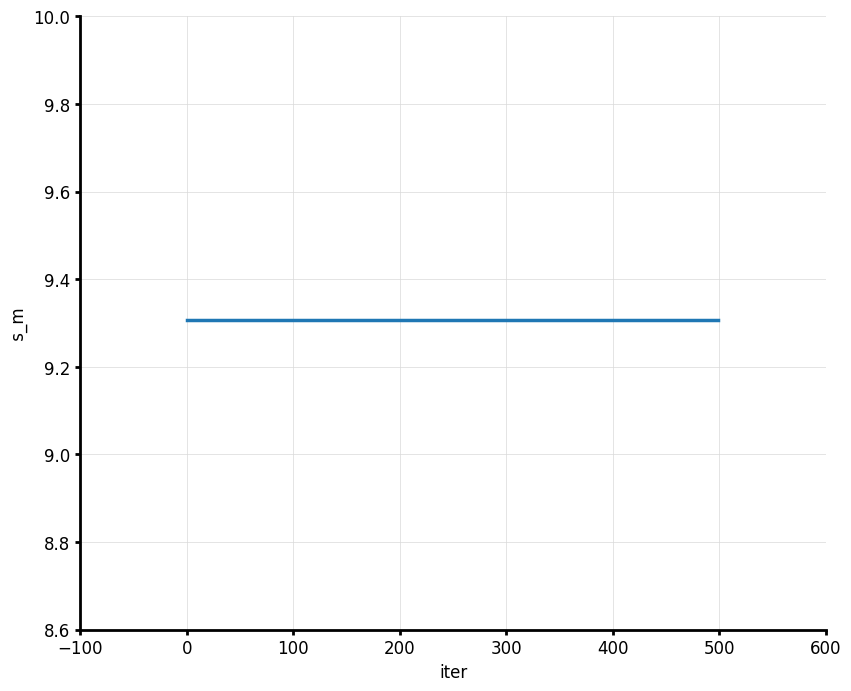

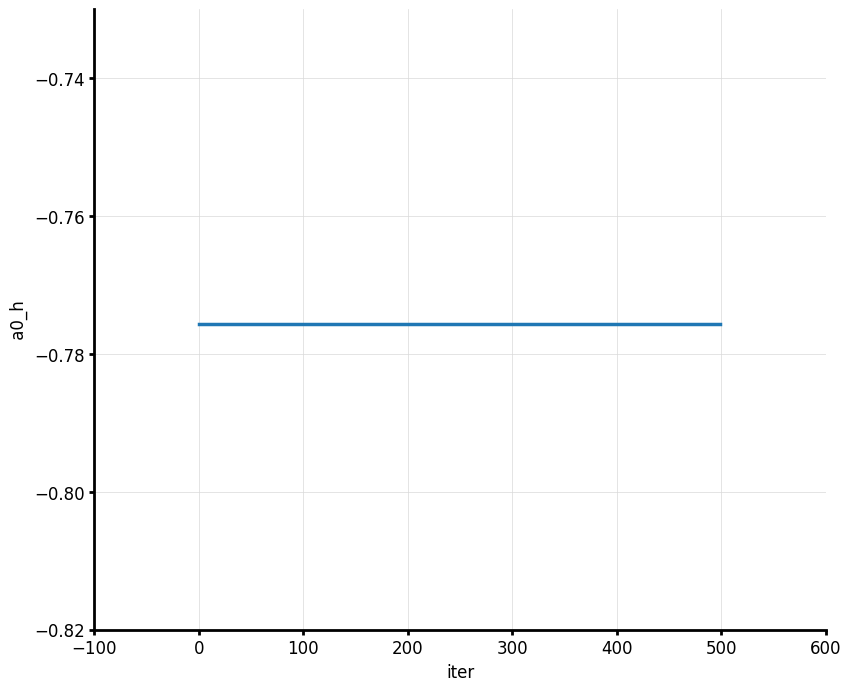

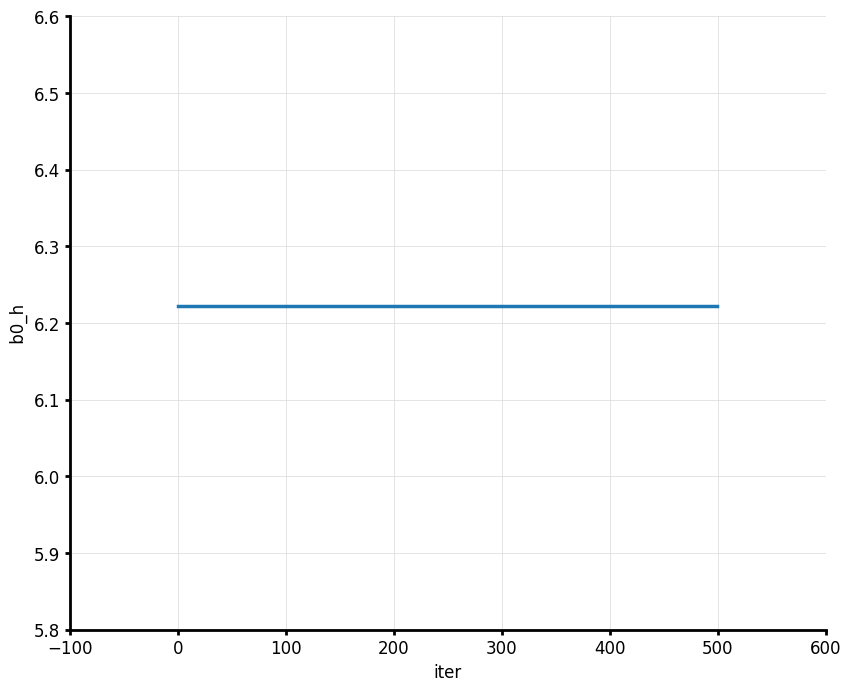

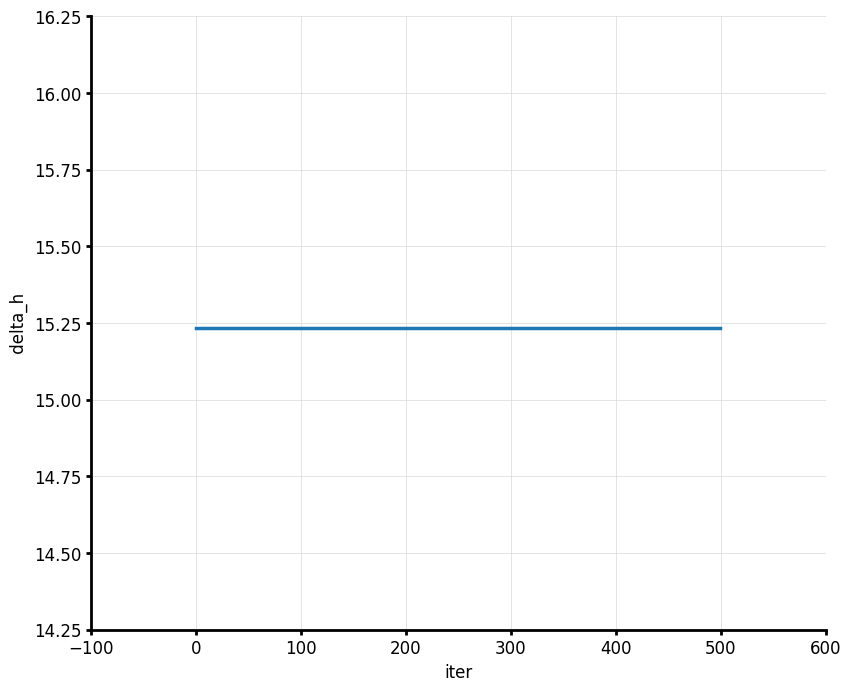

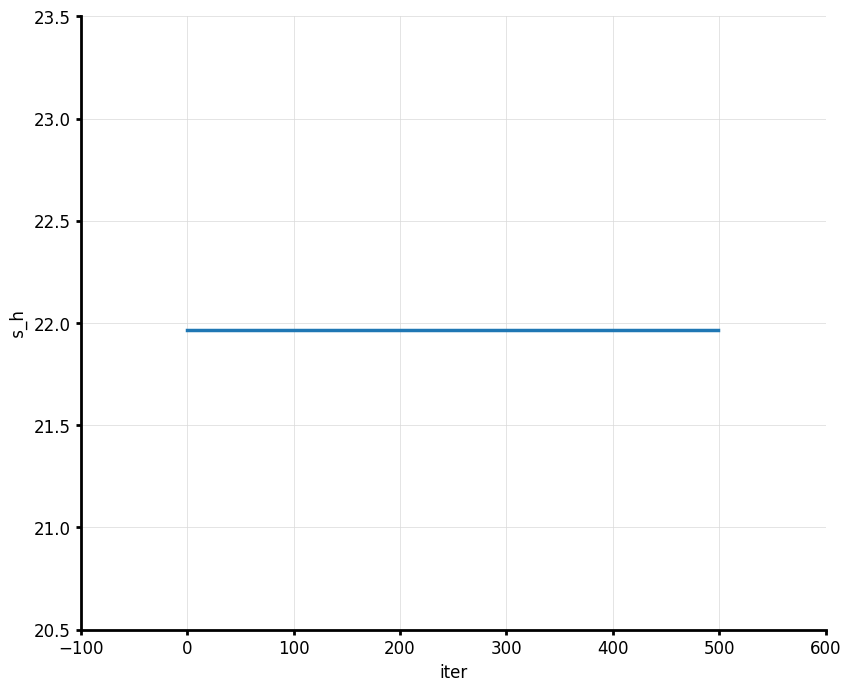

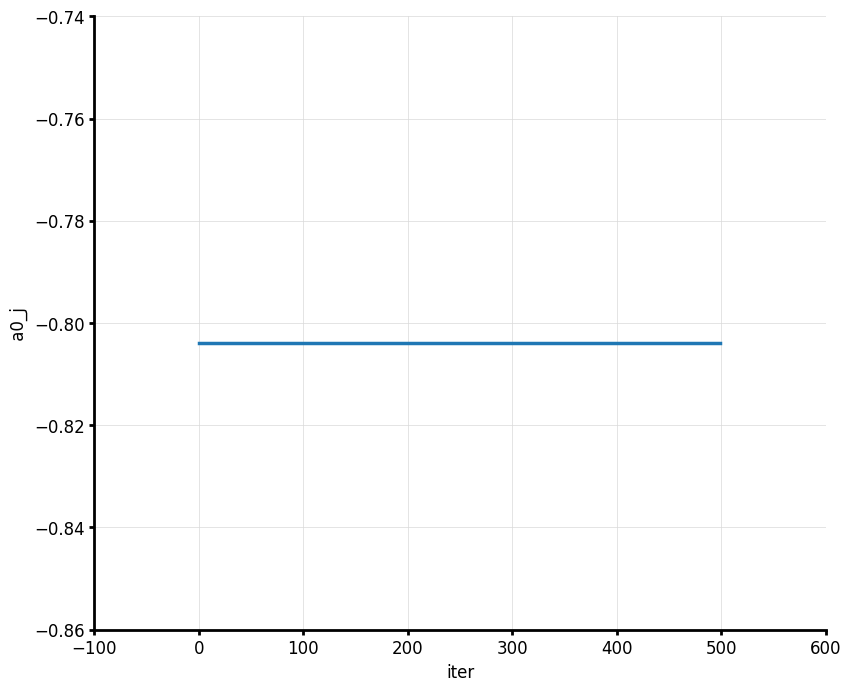

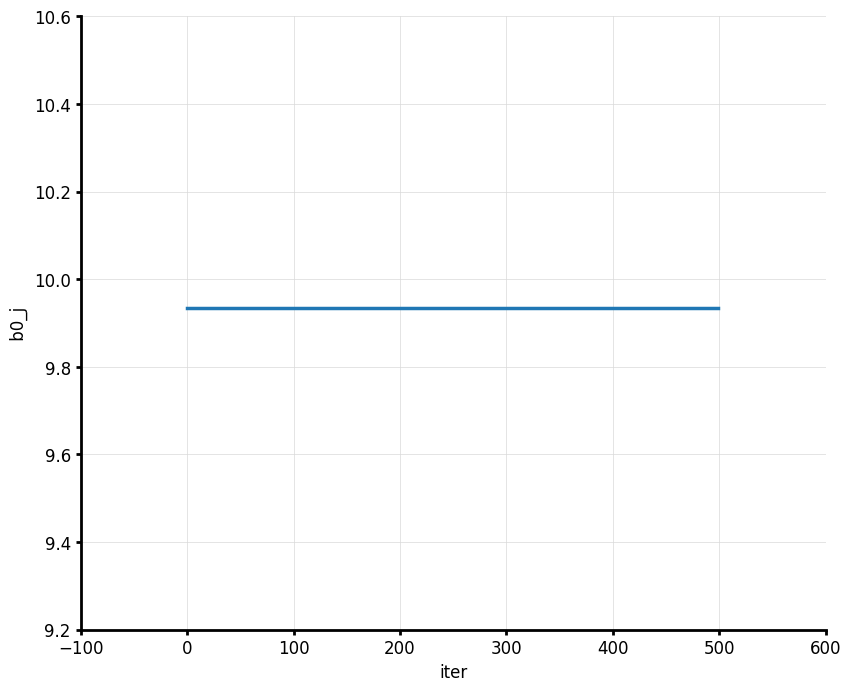

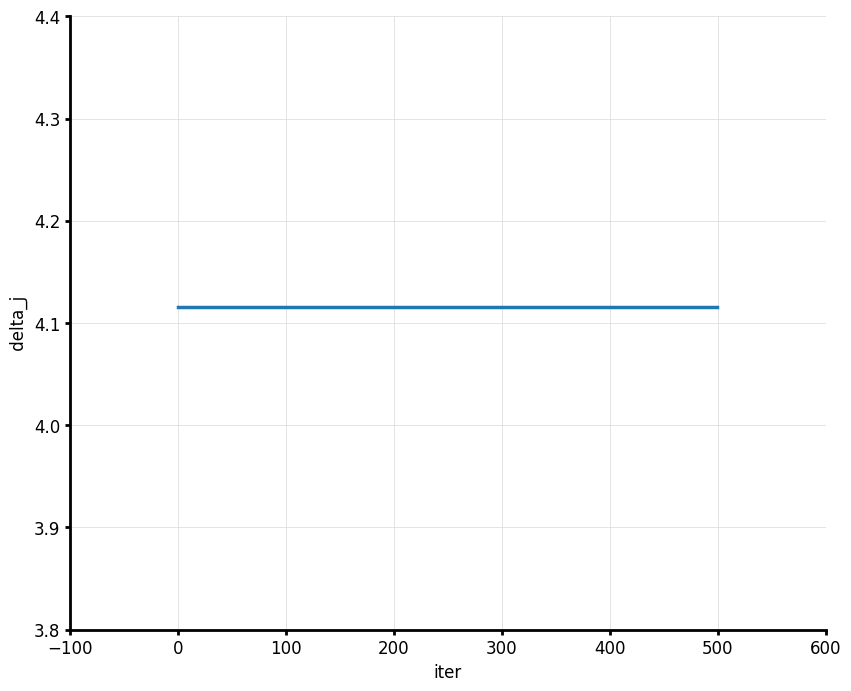

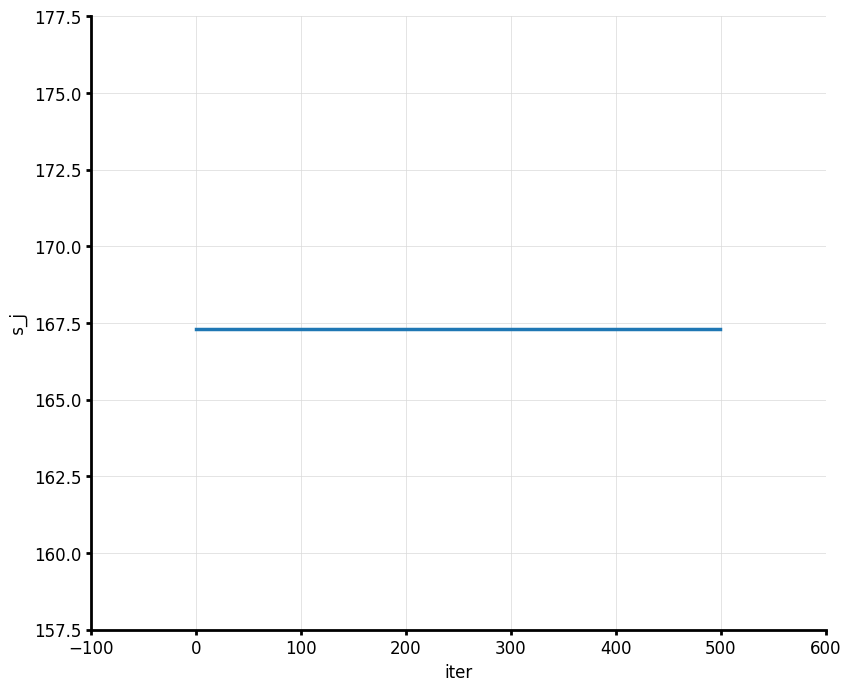

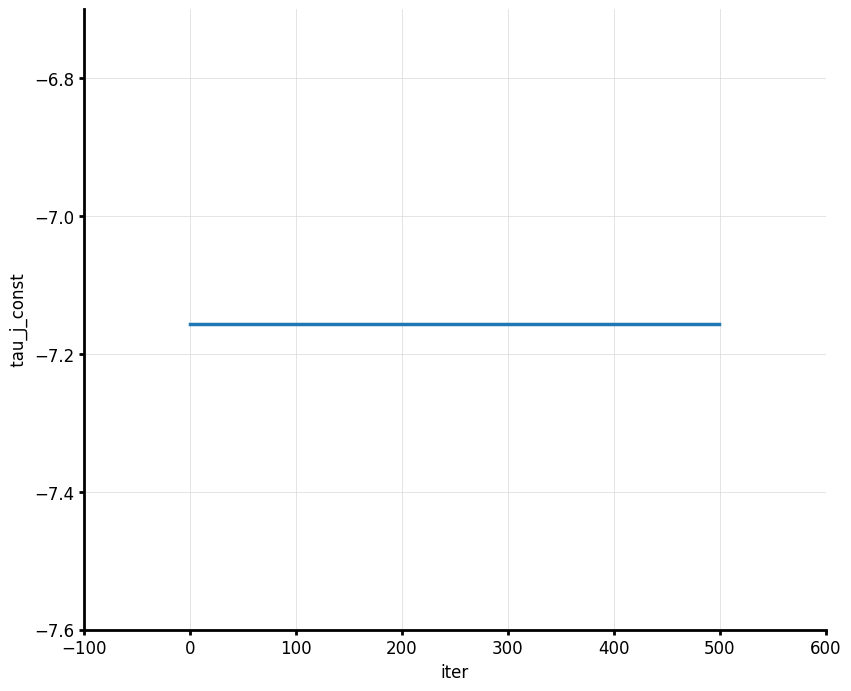

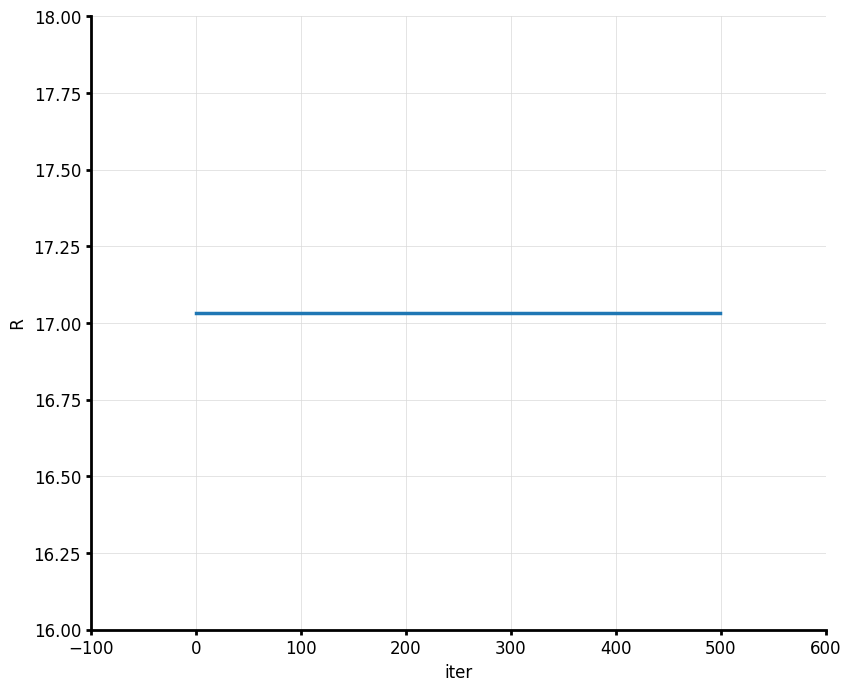

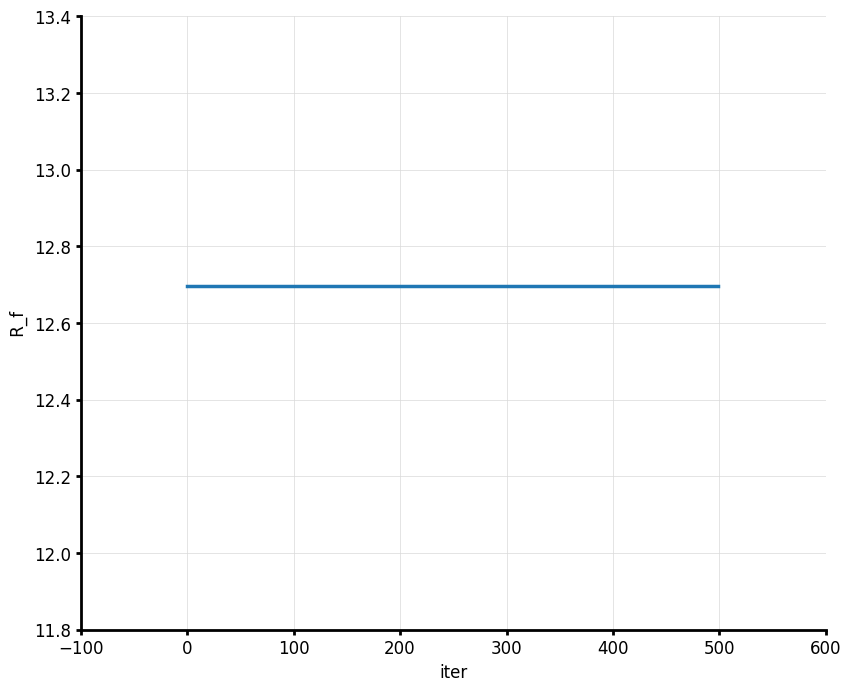

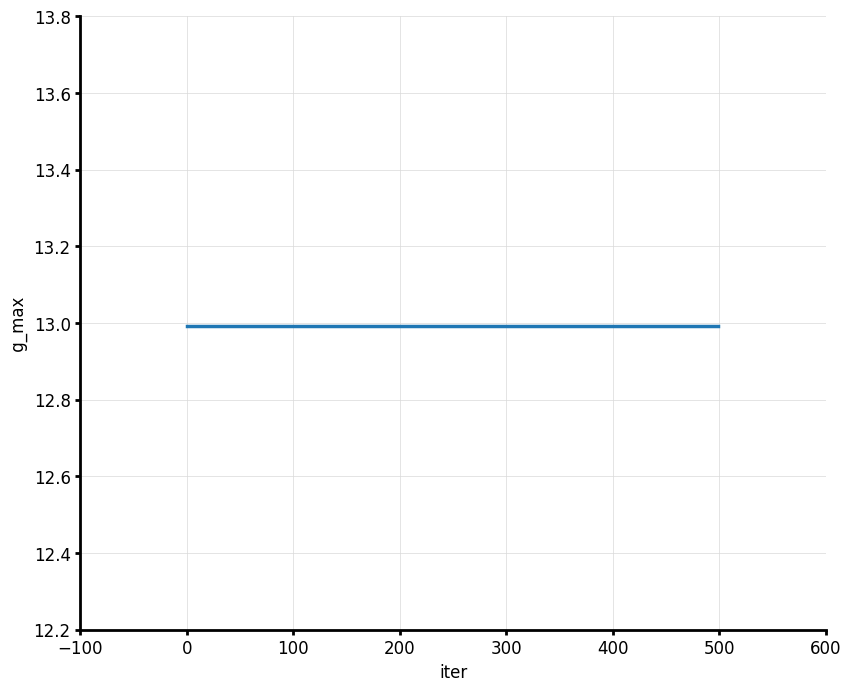

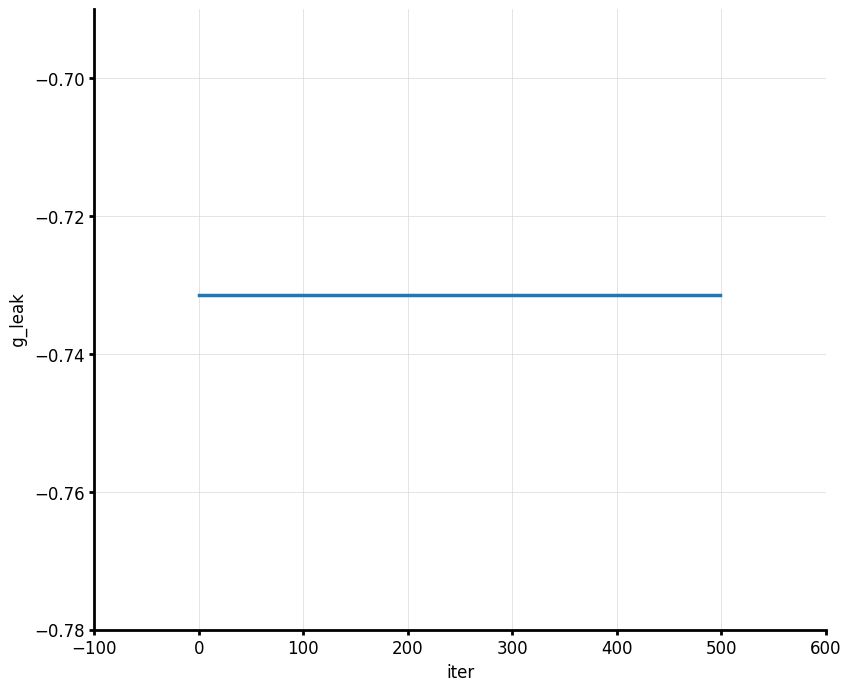

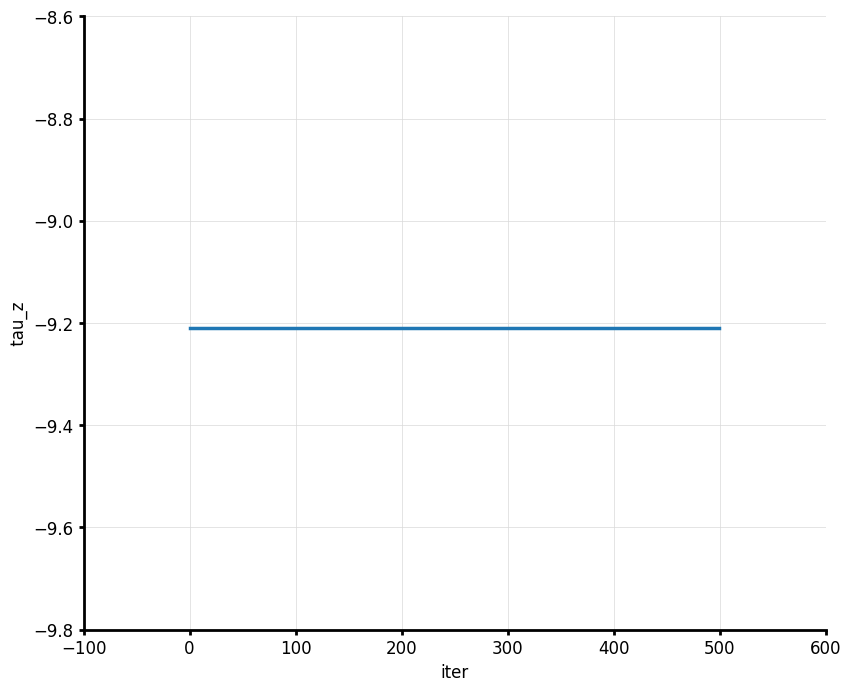

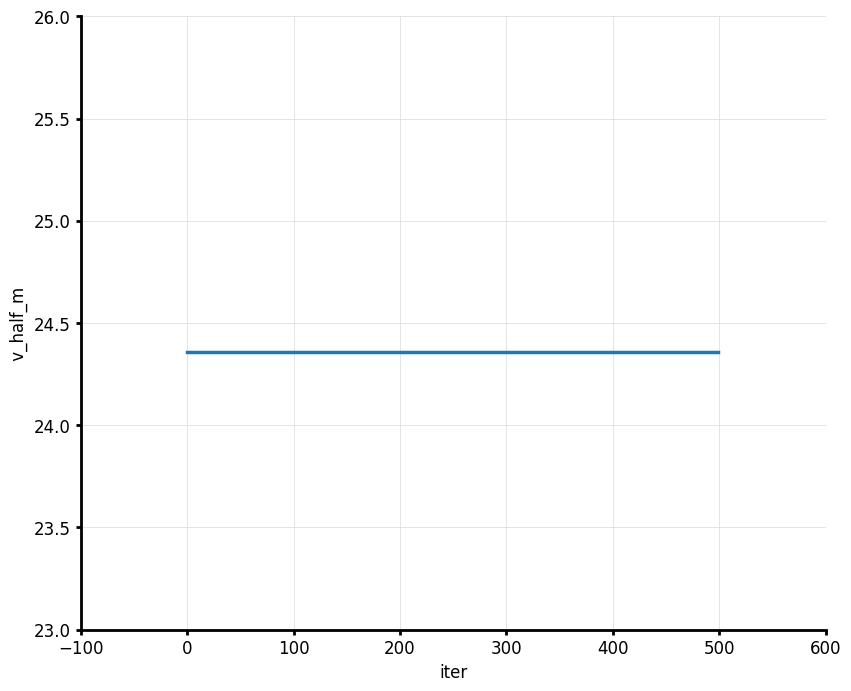

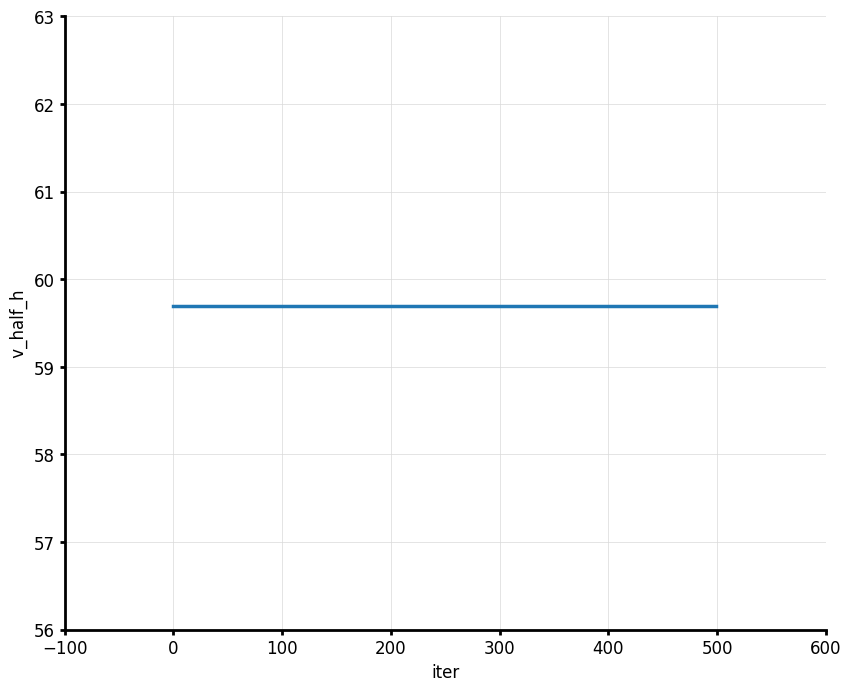

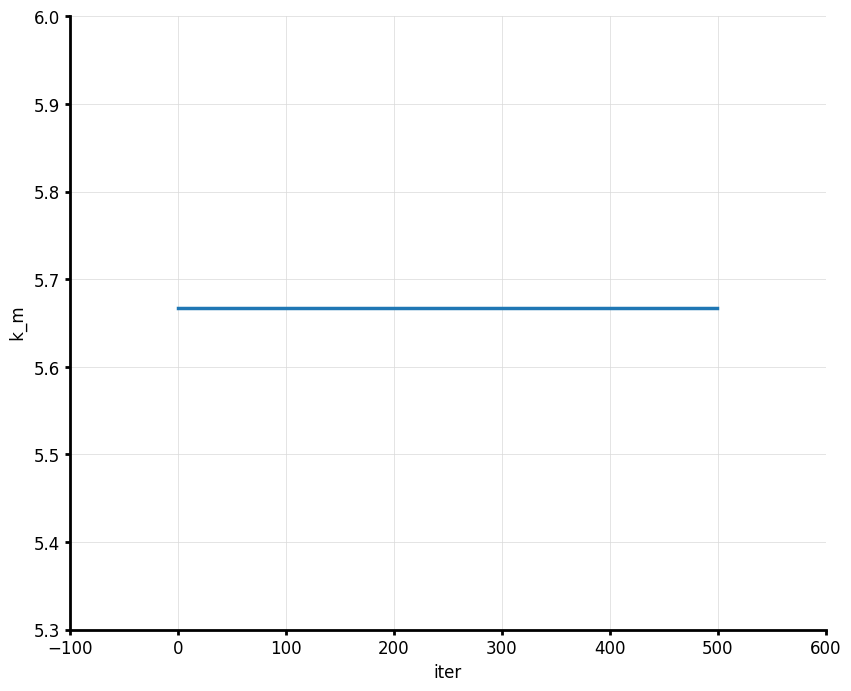

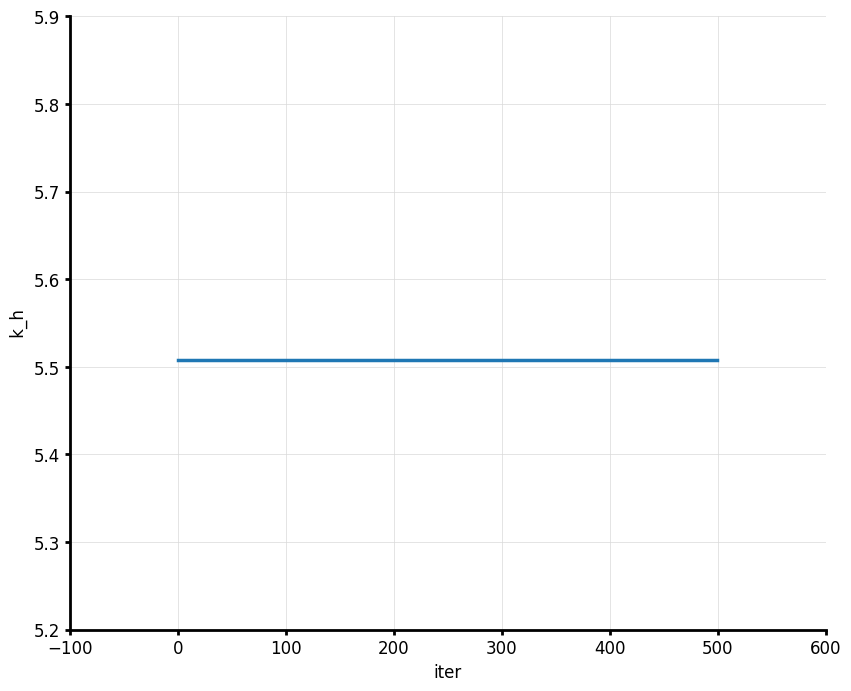

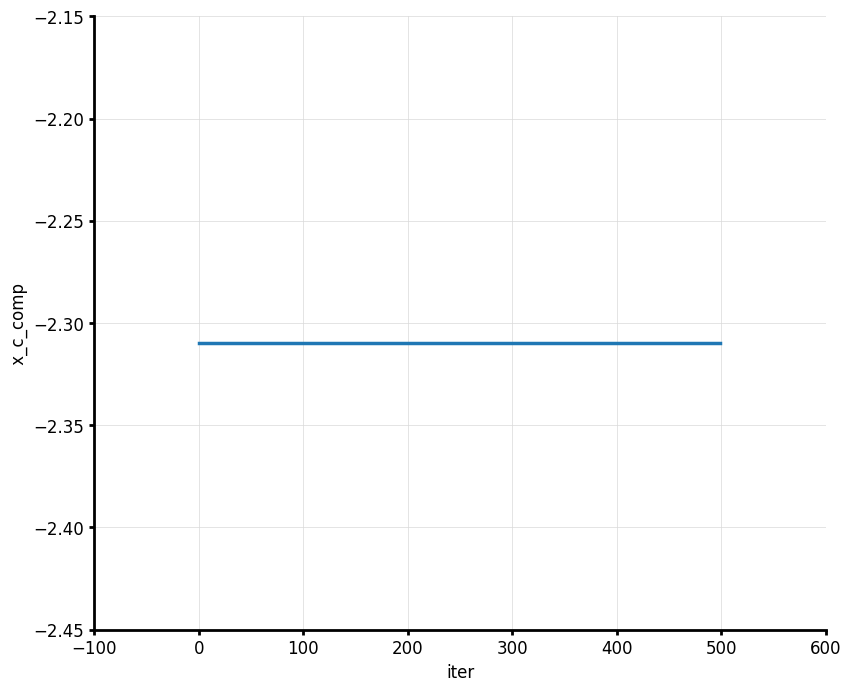

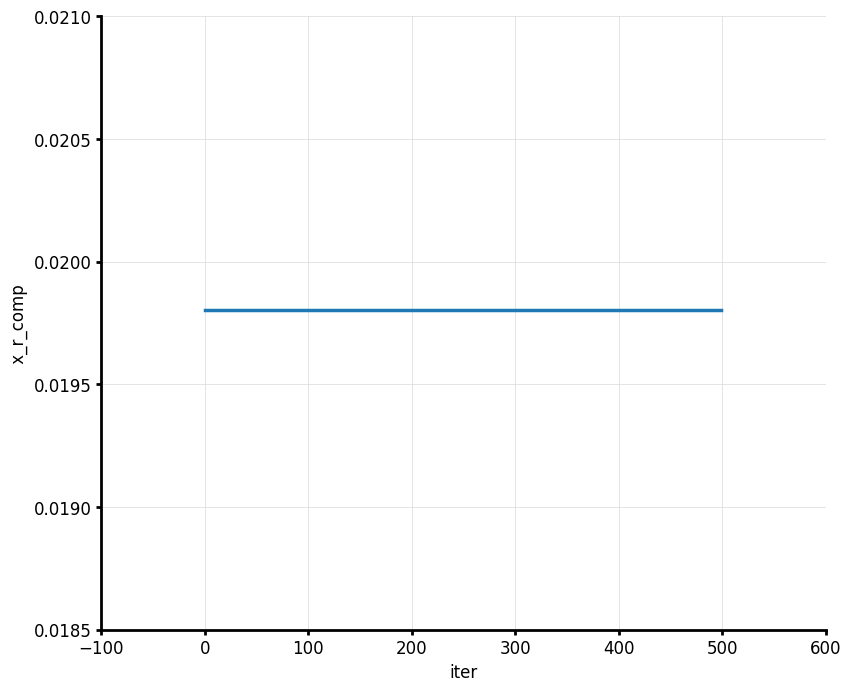

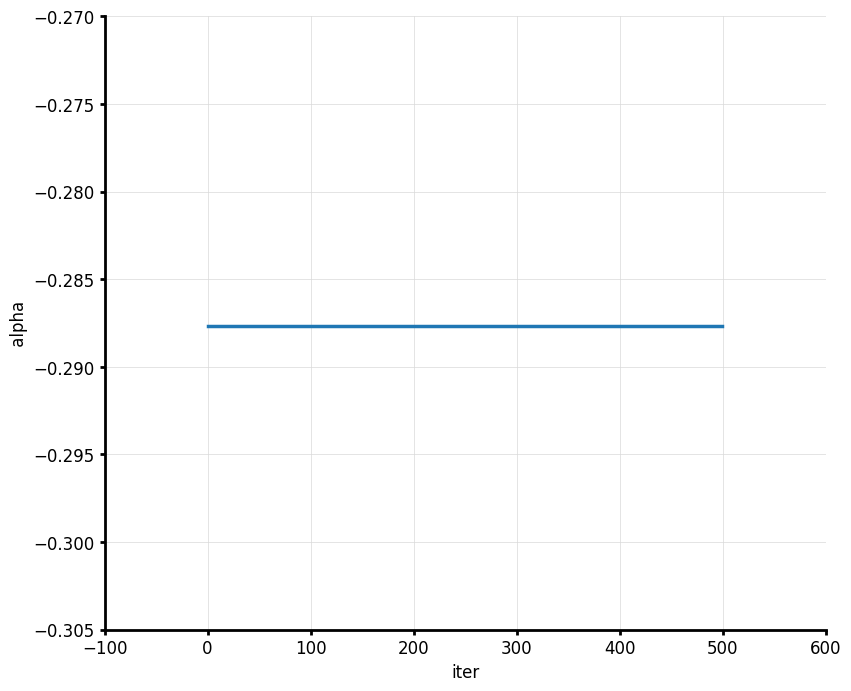

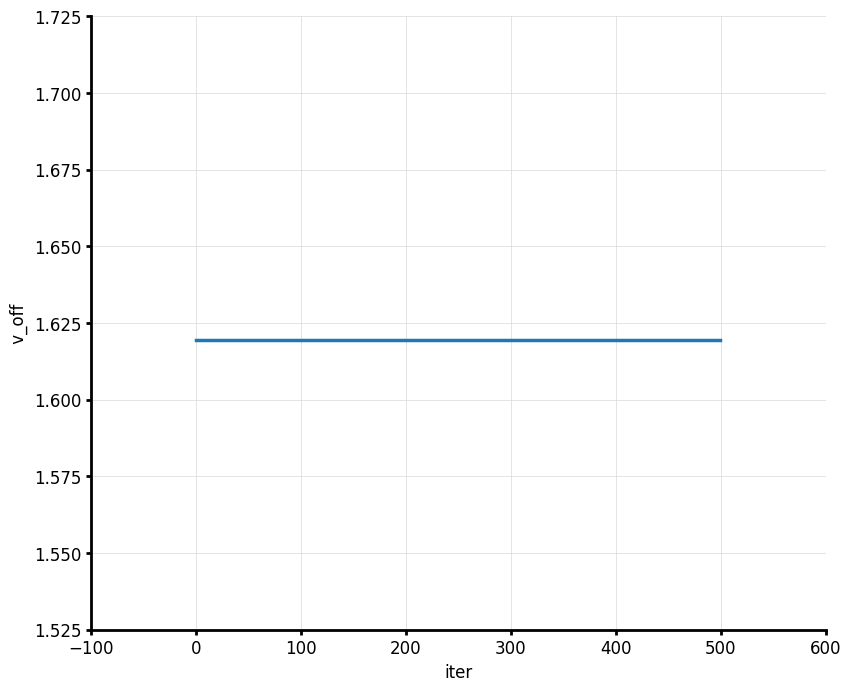

In [86]:
iterat = np.arange(0,500) 
for k in range(len(names)):
    plt.figure()
    plt.plot(iterat, chain.T[k])
    plt.xlabel('iter')
    plt.ylabel(names[k])

ValueError: x and y must have same first dimension, but have shapes (500, 28) and (28,)

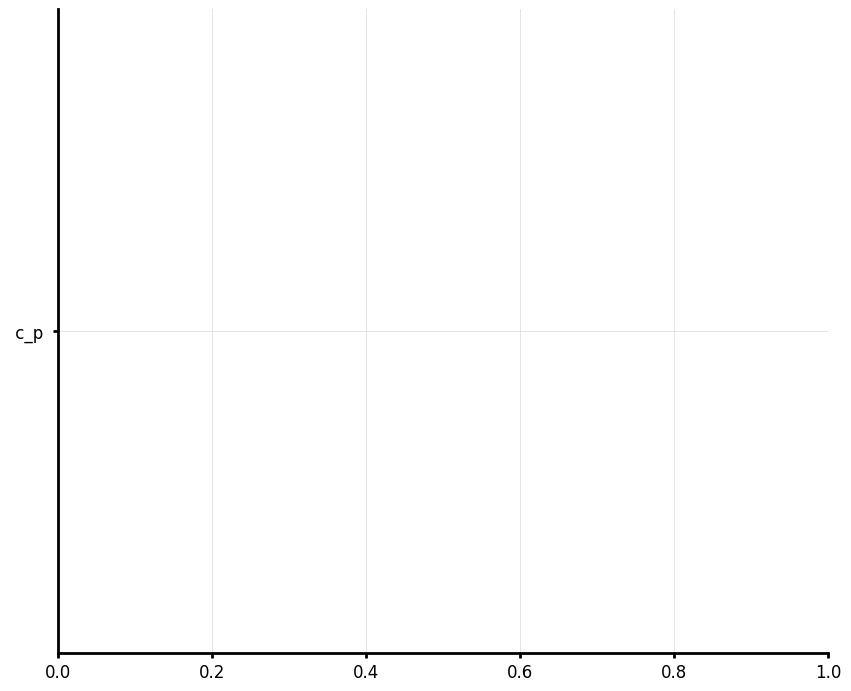

In [72]:
from pymcmcstat import mcmcplot as mcp


In [50]:
for k,l,m,n in zip(C.T.columns, p, spec_log_bounds[0],spec_log_bounds[1]):
    print("mcstat.parameters.add_model_parameter(name='",k,"', theta0=",l,", minimum=", m,
          ", maximum=", n,")")
    

mcstat.parameters.add_model_parameter(name=' с_p ', theta0= -26.126285491387264 , minimum= -32.23619130191664 , maximum= -26.021583203494448 )
mcstat.parameters.add_model_parameter(name=' c_m ', theta0= -24.422997564541507 , minimum= -25.328436022934504 , maximum= -23.131211445598282 )
mcstat.parameters.add_model_parameter(name=' a0_m ', theta0= 7.9146016329158435 , minimum= 6.907755278982137 , maximum= 9.210340371976184 )
mcstat.parameters.add_model_parameter(name=' b0_m ', theta0= 4.267724035266465 , minimum= 2.302585092994046 , maximum= 4.605170185988092 )
mcstat.parameters.add_model_parameter(name=' delta_m ', theta0= 20.6157 , minimum= 10.0 , maximum= 100.0 )
mcstat.parameters.add_model_parameter(name=' s_m ', theta0= 9.306083000000001 , minimum= 1.0 , maximum= 10.0 )
mcstat.parameters.add_model_parameter(name=' a0_h ', theta0= -0.7756483076716936 , minimum= -2.3025850929940455 , maximum= 0.0 )
mcstat.parameters.add_model_parameter(name=' b0_h ', theta0= 6.222195640086172 , minimu

In [348]:
bound_2 = [spec_log_bounds[0][8:10], spec_log_bounds[1][8:10]]
bound_2

[array([10., 10.]), array([100., 100.])]

## PyGMO


In [349]:
class ina_function_2:
    def __init__(self ):
        self.dim = 2
    def fitness(self, x):
        
        y = np.concatenate((p[:8], x, p[10:]))
        data = res_ina
        I_out = calculate_full_trace(y, kwargs)
        sample_weight = kwargs.get('sample_weight', None)
        if np.any(np.isnan(I_out)):
            return [np.inf]
        if np.any(np.isinf(I_out)):
            return [np.inf]
        return [MSE(data, I_out)]#, sample_weight=weight)]

    def get_bounds(self):
        return (bound_2)
    
prob = pg.problem(ina_function_2())     


In [350]:
y = p[8:10]
y

array([15.2348 , 21.96405])

In [351]:
prob.fitness(y)

array([0.])

In [352]:
%%time
algo = algorithm(sga(10))
#algo = algorithm(gaco(gen = 100))

pop = population(prob, 10, seed = 68)

pop = algo.evolve(pop) 

CPU times: user 10.4 s, sys: 19.6 ms, total: 10.4 s
Wall time: 10.6 s


In [353]:
pop.champion_f

array([30.68389491])

In [354]:
pop.champion_x

array([15.57259281, 37.19635128])

In [356]:
test = np.concatenate(( p[:8], pop.champion_x, p[10:]))
test

array([-2.61262855e+01, -2.44229976e+01,  7.91460163e+00,  4.26772404e+00,
        2.06157000e+01,  9.30608300e+00, -7.75648308e-01,  6.22219564e+00,
        1.55725928e+01,  3.71963513e+01, -8.03975730e-01,  9.93369323e+00,
        4.11530300e+00,  1.67315900e+02, -7.15694601e+00,  1.70322549e+01,
        1.26959445e+01,  1.29927566e+01, -7.31380238e-01, -9.21000043e+00,
        2.43580200e+01,  5.96911700e+01,  5.66677000e+00,  5.50777100e+00,
       -2.30961646e+00,  1.98026273e-02, -2.87682072e-01,  1.55814462e+00])

In [296]:
p0

array([ 4.502963e-12,  2.473016e-11,  2.736956e+03,  7.135904e+01,
        2.061570e+01,  9.306083e+00,  4.604052e-01,  5.038082e+02,
        1.523480e+01,  2.196405e+01,  4.475461e-01,  2.061333e+04,
        4.115303e+00,  1.673159e+02,  7.794313e-04,  2.494677e+07,
        3.264214e+05,  4.392204e+05,  4.812443e-01,  1.000340e-04,
        2.435802e+01,  5.969117e+01,  5.666770e+00,  5.507771e+00,
        9.929933e-02,  1.020000e+00,  7.500000e-01, -2.500000e+00])

In [344]:
test = despec_log_scale(test)

<IPython.core.display.Javascript object>


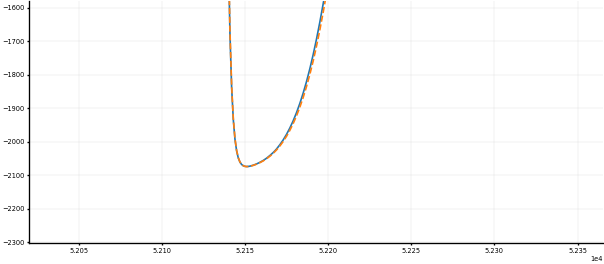

In [357]:
%matplotlib notebook
plt.plot(res_ina)
plt.plot(calculate_full_trace(test, kwargs), '--')

In [334]:
test = np.array([ 4.502963e-12,  2.473016e-11, #
                 2.736956e+03,  7.135904e+01,#
                 1.061570e+01,  1.306083e+00, 
                 4.604052e-01,  5.038082e+02,
                 1.523480e+01,  2.196405e+01,
                 4.475461e-01,  2.061333e+04,
                 4.115303e+00,  1.673159e+02, 
                 7.794313e-04,  2.494677e+07,
                 3.264214e+05,  4.392204e+05,  
                 4.812443e-01,  1.000340e-04,
                 2.435802e+01,  5.969117e+01,
                 5.666770e+00,  5.507771e+00,
                 9.929933e-02,  1.020000e+00, 
                 7.500000e-01, -2.500000e+00])

<IPython.core.display.Javascript object>


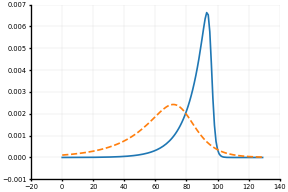

In [335]:
plt.figure()
plt.plot(tau_m(V,test))
plt.plot(tau_m(V,p0),'--')

In [276]:
y

array([-26.12628549, -24.42299756])

In [64]:
algo = algorithm(ihs(100))
topo = pg.fully_connected()

In [36]:
%%time
archi = pg.archipelago(n=500, t = topo, algo=algo, prob=prob, pop_size=5, seed = 38)


CPU times: user 3min 46s, sys: 579 ms, total: 3min 46s
Wall time: 3min 49s


In [ ]:
%%time
archi.evolve()

In [116]:
%%time
#algo = algorithm(gaco(gen = 100))
popul = population(prob, 50, seed = 68)
popul.push_back(x = x)



CPU times: user 6min 40s, sys: 232 ms, total: 6min 40s
Wall time: 6min 41s


In [143]:
%%time
pop = algo.evolve(popul) 

CPU times: user 2h 27min 29s, sys: 16.7 s, total: 2h 27min 45s
Wall time: 2h 29min 19s


In [43]:
archi.evolve()
archi.wait_check()

IndexError: 
function: get_migrants
where: /root/install/pagmo2-2.14.0/src/archipelago.cpp, 689
what: cannot access the migrants of the island at index 7: the migrants database has a size of only 5


In [168]:
arch

Number of islands: 5
Topology: Fully connected
Migration type: point-to-point
Migrant handling policy: preserve
Status: busy - **error occurred**

Islands summaries:

	#  Type                    Algo                          Prob                             Size  Status                     
	---------------------------------------------------------------------------------------------------------------------------
	0  Multiprocessing island  IHS: Improved Harmony Search  <class '__main__.ina_function'>  5     idle - **error occurred**  
	1  Multiprocessing island  IHS: Improved Harmony Search  <class '__main__.ina_function'>  5     idle - **error occurred**  
	2  Multiprocessing island  IHS: Improved Harmony Search  <class '__main__.ina_function'>  5     busy                       
	3  Multiprocessing island  IHS: Improved Harmony Search  <class '__main__.ina_function'>  5     busy                       
	4  Multiprocessing island  IHS: Improved Harmony Search  <class '__main__.ina_func

In [161]:
%%time
algo = algorithm(sga(gen = 10))
#algo.set_verbosity(50)

CPU times: user 108 µs, sys: 0 ns, total: 108 µs
Wall time: 113 µs


In [163]:
%%time
pop = population(prob, 1000, seed = 68)


CPU times: user 2min 7s, sys: 137 ms, total: 2min 7s
Wall time: 2min 10s


In [164]:
pop.champion_f

array([14231.23570778])

In [165]:
%%time
itog = algo.evolve(pop) 

CPU times: user 18min 50s, sys: 1.92 s, total: 18min 52s
Wall time: 19min 18s


In [166]:
itog.champion_f

array([3450.83667829])

In [167]:
pcx = itog.champion_x

<IPython.core.display.Javascript object>


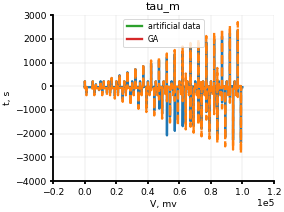

In [168]:
plt.figure()

plt.plot(res_ina)
plt.plot(calculate_full_trace(pop.champion_x, kwargs), '--')

In [110]:
pop.champion_f

array([3789.62492988])

In [111]:
pop

Problem name: <class '__main__.ina_function'>
	Global dimension:			28
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [-32.2362, -27.631, 4.60517, 0, 1, ... ]
	Upper bounds: [-27.631, -23.0259, 9.21034, 4.60517, 100, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 5007

	Thread safety: none

Population size: 5001

List of individuals: 
#0:
	ID:			17029972680052038987
	Decision vector:	[-30.3734, -24.0821, 5.28349, 2.4682, 7.12985, ... ]
	Fitness vector:		[3.86e+06]
#1:
	ID:			11844072779159721873
	Decision vector:	[-29.908, -25.4887, 6.97808, 1.36436, 55.3231, ... ]
	Fitness vector:		[25188.1]
#2:
	ID:			4692763806131821316
	Decision vector:	[-30.6209, -23.6463, 7.36121, 0.074353, 35.8562, ... ]
	Fitness vector:		[244266]
#3:
	I

In [221]:
df = pd.read_csv('../data/results/result_ina_ga.csv')
df

,loss,с_p,c_m,a0_m,b0_m,delta_m,s_m,a0_h,b0_h,delta_h,...,g_leak,tau_z,v_half_m,v_half_h,k_m,k_h,x_c_comp,x_r_comp,alpha,v_off
0,1643.060939,-28.263759,-24.704541,7.801261,2.498524,13.309220,9.421785,-0.765051,5.698668,44.374089,...,-0.923009,-9.519338,48.113103,60.837721,1.573601,2.672379,-3.695768,-2.216567,-0.240447,0.841037
1,1280.337903,-27.262724,-24.846062,9.172958,4.438690,28.919299,7.957613,-2.041175,5.780095,24.398448,...,-0.880463,-9.199115,34.020510,63.511906,7.281343,4.706251,-4.560933,-4.315703,-0.267424,0.961798


In [225]:
%matplotlib inline

In [222]:
pcx = df.iloc[1].values[1:]

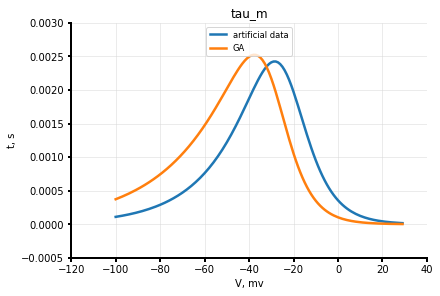

In [226]:
V = np.arange(-100, 30)
plt.title('tau_m')
plt.plot(V,tau_m(V, p0), label = "artificial data")
plt.plot(V,tau_m(V, despec_log_scale(pcx)), label = 'GA')
plt.xlabel('V, mv')
plt.ylabel('t, s')
plt.legend()

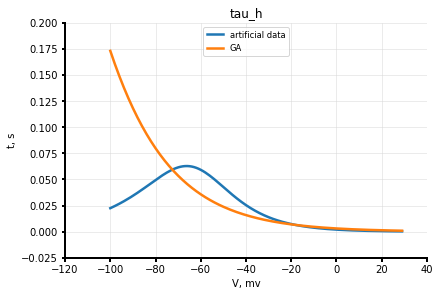

In [227]:
plt.title('tau_h')
plt.plot(V,tau_h(V, p0), label = "artificial data")
plt.plot(V,tau_h(V, despec_log_scale(pcx)), label = 'GA')
plt.xlabel('V, mv')
plt.ylabel('t, s')
plt.legend()

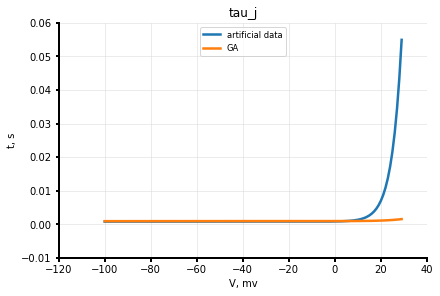

In [228]:
plt.title('tau_j')
plt.plot(V,tau_j(V, p0), label = "artificial data")
plt.plot(V,tau_j(V, despec_log_scale(pcx)), label = 'GA')
plt.xlabel('V, mv')
plt.ylabel('t, s')
plt.legend()

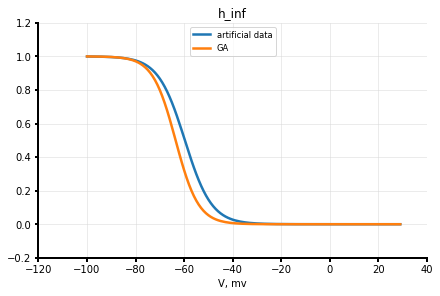

In [229]:
plt.title('h_inf')
plt.plot(V,h_inf(V, p0), label = "artificial data")
plt.plot(V,h_inf(V, despec_log_scale(pcx)), label = 'GA')
plt.xlabel('V, mv')
plt.legend()

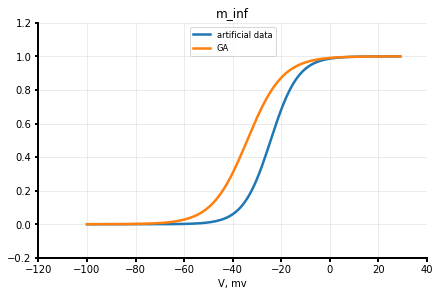

In [230]:
plt.title('m_inf')
plt.plot(V,m_inf(V, p0), label = "artificial data")
plt.plot(V,m_inf(V, despec_log_scale(pcx)), label = 'GA')
plt.xlabel('V, mv')
plt.legend()

In [158]:
%matplotlib notebook

<IPython.core.display.Javascript object>


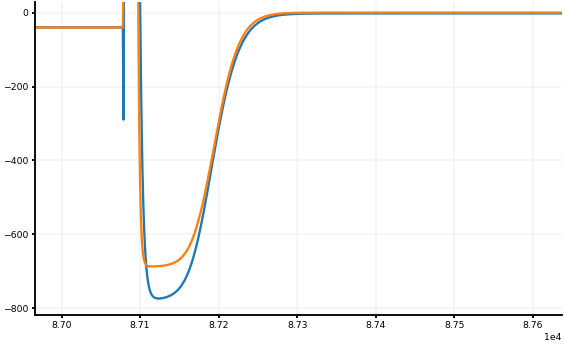

In [159]:
plt.figure()
plt.plot(calculate_full_trace(pcx, kwargs))
plt.plot(res_ina)

In [144]:
pop.champion_f

array([3789.62492988])

In [145]:
pop.champion_x

array([-2.60262855e+01, -2.43229976e+01,  8.01460163e+00,  4.36772404e+00,
        2.07157000e+01,  9.40608300e+00, -6.75648308e-01,  6.32219564e+00,
        1.53348000e+01,  2.20640500e+01, -7.03975730e-01,  1.00336932e+01,
        4.21530300e+00,  1.67415900e+02, -7.05694601e+00,  1.71322549e+01,
        1.27959445e+01,  1.30927566e+01, -6.31380238e-01, -9.11000043e+00,
        2.44580200e+01,  5.97911700e+01,  5.76677000e+00,  5.60777100e+00,
       -2.20961646e+00,  1.19802627e-01, -1.87682072e-01,  1.71938824e+00])

In [53]:
pcx =np.array([-2.91826271e+01, -2.41826759e+01,  7.19336510e+00,  1.28854979e+00,
        3.94355819e+00,  8.54829755e-01, -2.03146477e+00,  6.10844840e+00,
        1.59660635e+01,  9.64947069e+01, -2.64327834e+00,  1.05123996e+01,
        3.84750048e+00,  6.56493742e+02, -7.17371768e+00,  1.73044556e+01,
        1.37779529e+01,  1.26646362e+01, -8.93008667e-01, -9.22648887e+00,
        3.39379098e+01,  8.12975140e+01,  3.63682271e+00,  7.20635142e+00,
       -3.96919983e+00, -5.10671182e-01, -4.35623447e+00,  1.35053172e+00])

In [31]:
C.T.columns

Index(['с_p', 'c_m', 'a0_m', 'b0_m', 'delta_m', 's_m', 'a0_h', 'b0_h',
       'delta_h', 's_h', 'a0_j', 'b0_j', 'delta_j', 's_j', 'tau_j_const', 'R',
       'R_f', 'g_max', 'g_leak', 'tau_z', 'v_half_m', 'v_half_h', 'k_m', 'k_h',
       'x_c_comp', 'x_r_comp', 'alpha', 'v_off', 'v_rev', 'v_c'],
      dtype='object', name='name')

In [255]:
xo = np.array([-29.58129311, -24.28015581,   9.03892506,   4.5028152 ,
        12.98119638,   9.84277396,  -4.32132691,   4.5201081 ,
        23.74676722,  67.54609846,  -2.06132096,   9.58568017,
         9.55158447, 439.67486758,  -8.32732281,  17.2578538 ,
        13.333411  ,  13.77848102,  -1.82531426,  -6.97260164,

        48.2252041 ,  99.28393868,   7.79401085,   4.9594516 ,
        -4.508712  ,  -4.08325631,  -2.36428991,   0.5653913 ])

In [42]:
despec_log_scale(pop1.champion_x )

NameError: name 'pop1' is not defined

In [292]:
p0

array([ 4.502963e-12,  2.473016e-11,  2.736956e+03,  7.135904e+01,
        2.061570e+01,  9.306083e+00,  4.604052e-01,  5.038082e+02,
        1.523480e+01,  2.196405e+01,  4.475461e-01,  2.061333e+04,
        4.115303e+00,  1.673159e+02,  7.794313e-04,  2.494677e+07,
        3.264214e+05,  4.392204e+05,  4.812443e-01,  1.000340e-04,
        2.435802e+01,  5.969117e+01,  5.666770e+00,  5.507771e+00,
        9.929933e-02,  1.020000e+00,  7.500000e-01, -2.500000e+00])

<IPython.core.display.Javascript object>


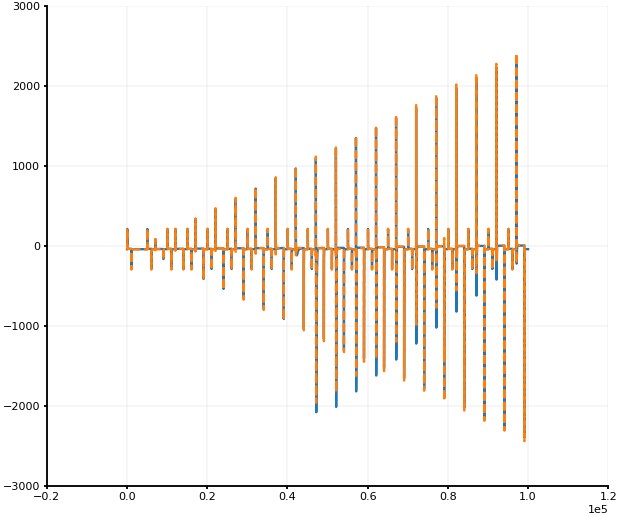

In [302]:
plt.figure()
plt.plot(res_ina)
#plt.plot(calculate_full_trace(pop.champion_x, kwargs),'--')
plt.plot(calculate_full_trace(pop1.champion_x, kwargs),'--')
#plt.plot(calculate_full_trace(xo, kwargs))

In [ ]:
%%time
isl = island(algo, prob, 20) 
isl.evolve(10)
isl.join()

## Something else

In [22]:
k_list = np.array([79, 1079, 2079, 4079])
k_all = k_list
for l in range(1,20):
    k_all = np.concatenate([k_all, k_list+5000*l])


In [23]:
dt = 5e-5
protocol = pd.DataFrame(np.vstack([np.array([0,*k_all]) * dt, v_all]).T, columns=['t', 'v'])

protocol = interp1d(df_protocol.t, protocol.v, kind='previous', bounds_error=False, fill_value=-80.)


In [24]:
#protocol_to_csv = pd.DataFrame(np.stack([t, protocol(t)]).T, columns=['t', 'v'])
#protocol_to_csv.to_csv('../../INa_full_trace/data/protocols/protocol_79.csv')

In [26]:
data = pd.read_csv('../data/training/2020_12_19_0035 I-V INa 11,65 pF.atf' ,delimiter= '\t', header=None, skiprows = 11)
exp_data = np.concatenate([data[k] for k in range(1,21)])

In [39]:
%%time
x = scale(C.value.values[:-2],*bounds)
res = scop.minimize(loss,res.x, args = (exp_data, kwargs),method = 'Nelder-Mead',\
                    options={'adaptive':True, 'maxiter':100})
   

CPU times: user 1min 44s, sys: 8.94 ms, total: 1min 44s
Wall time: 1min 44s


In [26]:
result = pd.read_csv('../../INa_full_trace_old/data/results/result_old.csv')
resulto = result.iloc[-1:].values[0]
result.iloc[-1:]

In [265]:
fitness_function = loss1

num_generations = 1000
num_parents_mating = 6
initial_population = x
sol_per_pop = 10
num_genes = len(x)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10
gene_space = scale_bounds

In [266]:
%%time
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space=gene_space,
                      )
ga_instance.run()

CPU times: user 5min 2s, sys: 836 ms, total: 5min 3s
Wall time: 5min 8s


In [194]:
%%time
if __name__ == "__main__":
    mean = np.zeros(28)
    sigma = 0.5
    optimizer = CMA(mean=mean, sigma=sigma, bounds=bounds, seed=0)
    for generation in range(1):
        solutions = []
        for _ in range(optimizer.population_size):
            x = optimizer.ask()
            value = loss(x,exp_data, kwargs)
            solutions.append((x, value))
            #print(f"#{generation} {value} (x={x})")
        optimizer.tell(solutions)


CPU times: user 8.87 s, sys: 801 µs, total: 8.87 s
Wall time: 8.87 s


/home/nik/.local/lib/python3.8/site-packages/cmaes/_cma.py:319: RuntimeWarning: overflow encountered in exp
  self._sigma *= np.exp(


In [294]:
result = pd.read_csv("../data/results/result_1.csv", index_col=0)


In [295]:
a = [0.5229974 , 0.25433779, 0.61332585 ,0.67833989, 0.52493476 ,0.40349649,
 0.78503966 ,0.73759595 ,0.50380974, 0.64720374, 0.69399094, 0.4966301,
 0.41924955 ,0.65354898 ,0.33269649, 0.9986073 , 0.02609741, 0.54361373,
 0.51302827 ,0.20847538 ,0.80373068, 0.45101004, 0.58051384 ,0.56345914,
 0.56346415 ,0.72196668 ,0.44092185, 0.94218296]

In [328]:
data = calculate_full_trace(x0, kwargs)
data_a = calculate_full_trace(a, kwargs)